<a target="_blank" href="https://colab.research.google.com/github/ginal001/ML-2024-2025/blob/main/Lab9/Homework09.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# MNIST dataset
----------------------

In this workshop, we will construct an MLP network designed to a specific task of classification of MNIST dataset: a set of handwritten digits from *zero* to *nine*. MNIST stands for Modified National Institute of Standards and Technology database.

**You can read more about this dataset [here](https://colah.github.io/posts/2014-10-Visualizing-MNIST/#MNIST).**




# Multi Layer Perceptron Notation
---------------------------------

In this workshop we will be classifying 28 by 28 images into 10 classes. Thus, a four layer perceptron (our classificator) we will work further with can be defined as
$\hat f:\mathbb{R}^{28\cdot 28} \rightarrow \mathbb{R}^{10}$ defined as

$$\hat f \left(x; W_1, W_2, W_3, W_4, b_1, b_2, b_3, b_4 \right) =  W_4 \left[ W_3 \left[ W_2 \left[ W_1 x  + b_1 \right]_+  + b_2 \right]_+  + b_3 \right]_+ + b_4,$$

where matrices $W_1, \ldots, W_4$ are tensors of order two (matrices) with matching dimensions and bias terms $b_1, \ldots, b_4$ are tensors of order one (vectors) of matching dimensions, and we are using ReLU activation.

Note, that there is no nonlinear activation after the last layer in our neural network. **There is an implicit softmax applied while cross entropy loss is calculated by `torch.nn.functional`.**


# Reading MNIST Dataset to Play with It
--------------------

In [1]:
import torch
import torchvision
from matplotlib import pyplot

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

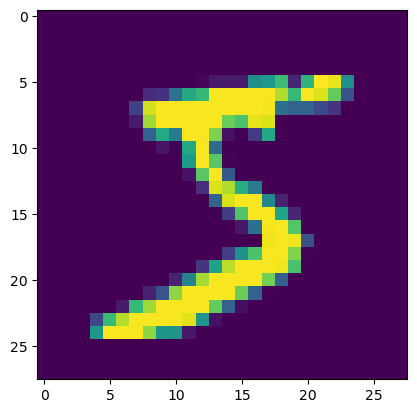

In [2]:
train_image, train_target = trainset[0]    #let us examine the 0-th sample
pyplot.imshow(train_image)
pyplot.show()

In [3]:
trainset.data[0]     #it will be shown in two rows, so a human has hard time classificating it

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [4]:
trainset[0][1]    #check if you classified it correctly in your mind

5

# Rereading the MNIST Data (Serious Preparation for Training)
------------------

In [5]:
(trainset.data.numpy().mean()/255.0, trainset.data.numpy().std()/255.0)   #MNIST datapoints are RGB integers 0-255

(np.float64(0.1306604762738429), np.float64(0.30810780385646264))

# Task
---------------

Why do we need to normalize the data, and not feed the NN with the 0-255 integers?

In [6]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

## Visualizing Data


### Labels (Ground Truth Outputs)

In [7]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i<5:
            print(i, "-th batch labels :", batch_labels)

0 -th batch labels : tensor([2, 7, 4,  ..., 4, 0, 0])
1 -th batch labels : tensor([4, 7, 8,  ..., 1, 8, 7])
2 -th batch labels : tensor([8, 4, 4,  ..., 7, 1, 5])
3 -th batch labels : tensor([8, 1, 2,  ..., 9, 7, 8])
4 -th batch labels : tensor([3, 3, 2,  ..., 6, 6, 1])


A single label is an entity of order zero (a constant), but batched labels are of order one. The first (and only) index is a sample index within a batch.

### Inputs

In [8]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i==0:
            print(i, "-th batch inputs :", batch_inputs)

0 -th batch inputs : tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
     

OK, so each data image was initially a two dimensional image when we first saw it, but now the batches have order 4. The first index is a sample index within a batch, but a second index is always 0. This index represents a Channel number inserted here by `ToTensor()` transformation, always 0. As this order is one-dimensional, we can get rid of it, later, in training, in `Flatten` layer or by using `squeeze()` on a tensor.

# MLP Definition
-----------------

Your job now is to take the (fully functional) definition of the MLP structure and get rid off the Sequential layer.


In [9]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),            #ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [10]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.304459810256958
epoch: 0 batch: 1 current batch loss: 2.0750486850738525
epoch: 0 batch: 2 current batch loss: 1.6248425245285034
epoch: 0 batch: 3 current batch loss: 1.1525583267211914
epoch: 0 batch: 4 current batch loss: 1.004474401473999
epoch: 0 batch: 5 current batch loss: 1.0406378507614136
epoch: 0 batch: 6 current batch loss: 1.0052214860916138
epoch: 0 batch: 7 current batch loss: 1.259653091430664
epoch: 0 batch: 8 current batch loss: 0.7739486694335938
epoch: 0 batch: 9 current batch loss: 0.5779260396957397
epoch: 0 batch: 10 current batch loss: 0.6629816889762878
epoch: 0 batch: 11 current batch loss: 0.6619174480438232
epoch: 0 batch: 12 current batch loss: 0.5735514760017395
epoch: 0 batch: 13 current batch loss: 0.5321135520935059
epoch: 0 batch: 14 current batch loss: 0.4751400947570801
epoch: 0 batch: 15 current batch loss: 0.4897471070289612
epoch: 0 batch: 16 current batch loss: 0.4492625892162323
epoch: 0 ba

# Testing
----------------------

Correct the code below so it works.

In [11]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9812


# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




# Solution

# Creating numbers from training input

First, let’s define the function we’ll use to train the input. It will take a neural network and train the input until we reach our desired criteria (in our case, a classification probability above 0.99999 or 40_000 iterations). We also add an additional parameter, $\lambda$, which governs the penalty introduced earlier. It’s worth noting that we freeze the network’s parameters and train only the input points.

In [12]:
def plot_numbers(points):   #function for plotting trained points
    
    fig, axes = pyplot.subplots(1, 10, figsize=(15, 3))

    for i, ax in enumerate(axes):
        img = points[i].squeeze().detach().cpu().numpy()
        ax.imshow(img)      
        ax.set_title(f"{i}")            
        ax.axis('off')             

    pyplot.tight_layout()
    pyplot.show()



def train_input(net, lambda_l2 = 0, lr = 0.001, prob = 0.99999, plot = False, info = 2000, max_iter = 40000):   # main function
    
    net.eval()
    for parameters in net.parameters():
        parameters.requires_grad = False   # freezing model
    
    points = torch.randn(10, 1, 28, 28).to(device)
    points.requires_grad = True
    true = torch.LongTensor(range(0,10)).to(device)   # defining random noise and output
    
    optimizer = torch.optim.Adam([points], lr)

    epoch = 0
    
    while ( not all([torch.max(torch.nn.functional.softmax(net(points[number]), dim = 1)) > prob for number in range(0,10)]) ) and (epoch < max_iter):
    
        optimizer.zero_grad()
        preds = net(points)   
        loss = torch.nn.functional.cross_entropy(preds, true, reduction = "mean") + lambda_l2 * points.pow(2).mean()
    
        epoch += 1
        if epoch % info == 0:
            with torch.no_grad():
                print("Iteration", epoch, "current batch loss:", loss.item())
                print("Predicted value: ", [torch.argmax(torch.nn.functional.softmax(net(points[number]), dim = 1)).item() for number in range(0,10)], "\n", 
                  "Predicted probability: ", [round(torch.max(torch.nn.functional.softmax(net(points[number]), dim = 1)).item(), 6) for number in range(0,10)])
                if plot:
                    plot_numbers(points)
        
        loss.backward()     
        optimizer.step()     

    print("Iteration", epoch, "current batch loss:", loss.item())
    
    for parameters in net.parameters():
        parameters.requires_grad = False  # unfreezing model
        
    return points

# Case: $\lambda = 0$

Iteration 2000 current batch loss: 0.0016843151533976197
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.998091, 0.997062, 0.998917, 0.99834, 0.997765, 0.998662, 0.997662, 0.999876, 0.998039, 0.998761]


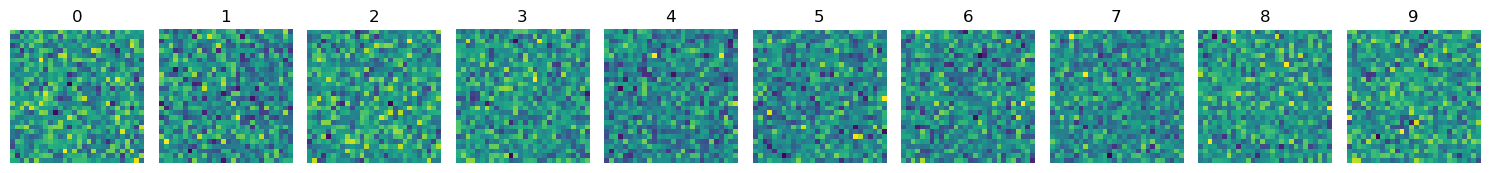

Iteration 4000 current batch loss: 0.00040486687794327736
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999514, 0.999322, 0.999755, 0.999603, 0.999444, 0.999674, 0.999399, 0.999972, 0.999534, 0.999736]


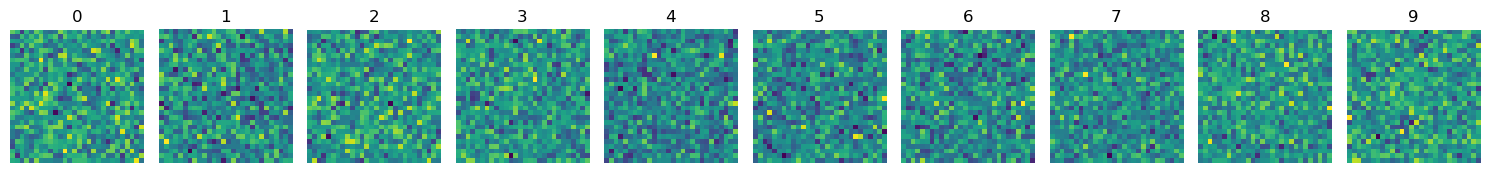

Iteration 6000 current batch loss: 0.0001347430661553517
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999833, 0.999774, 0.999925, 0.999866, 0.999815, 0.999892, 0.999788, 0.999991, 0.999852, 0.999916]


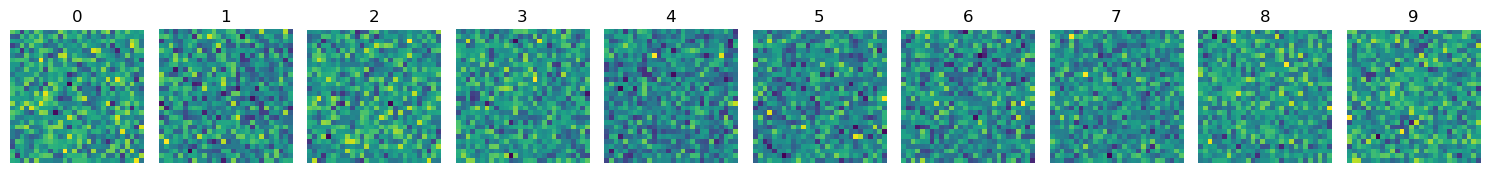

Iteration 8000 current batch loss: 4.8600159061606973e-05
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999935, 0.999919, 0.999976, 0.999951, 0.999933, 0.999962, 0.999921, 0.999997, 0.999948, 0.999971]


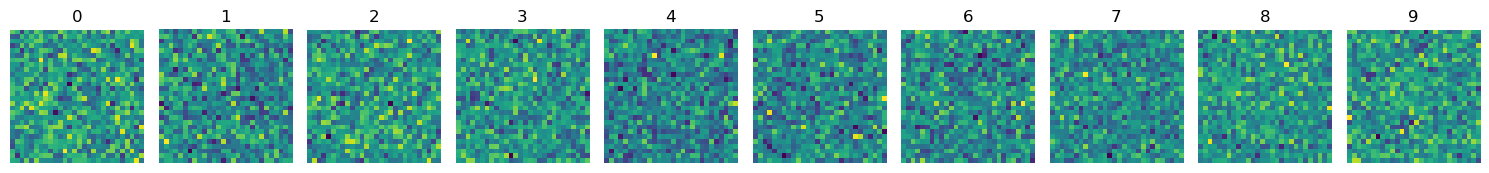

Iteration 10000 current batch loss: 1.7940797988558188e-05
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999975, 0.999971, 0.999992, 0.999982, 0.999975, 0.999986, 0.99997, 0.999999, 0.999981, 0.99999]


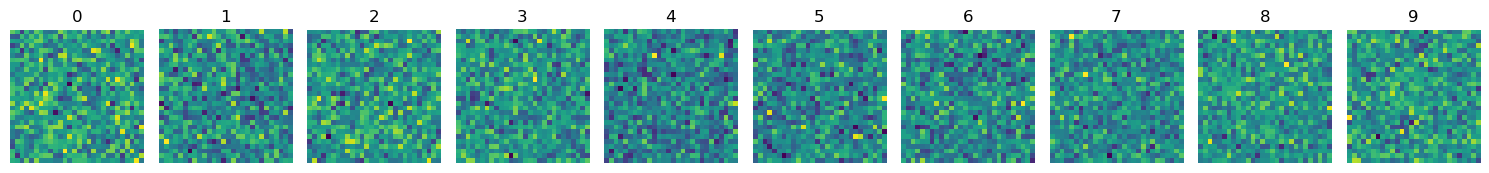

Iteration 12000 current batch loss: 6.639929779339582e-06
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999991, 0.99999, 0.999997, 0.999993, 0.99999, 0.999995, 0.999989, 1.0, 0.999993, 0.999996]


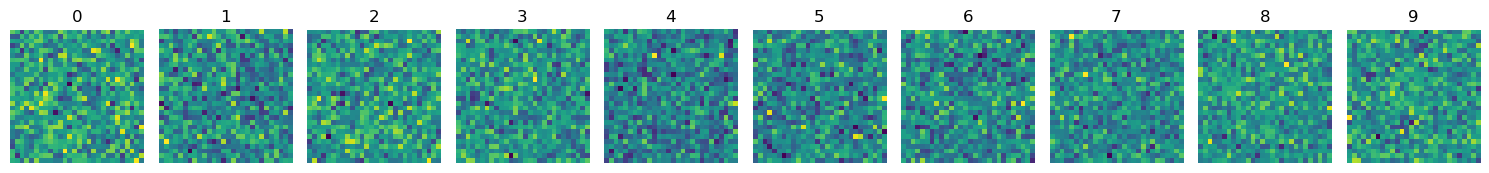

Iteration 12281 current batch loss: 5.769708423031261e-06


In [13]:
points_1 = train_input(net, plot = True)

# Case: $\lambda = 0.001$

Iteration 2000 current batch loss: 0.0025555621832609177
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99829, 0.998365, 0.997424, 0.999344, 0.997051, 0.999914, 0.998424, 0.998937, 0.998356, 0.99828]


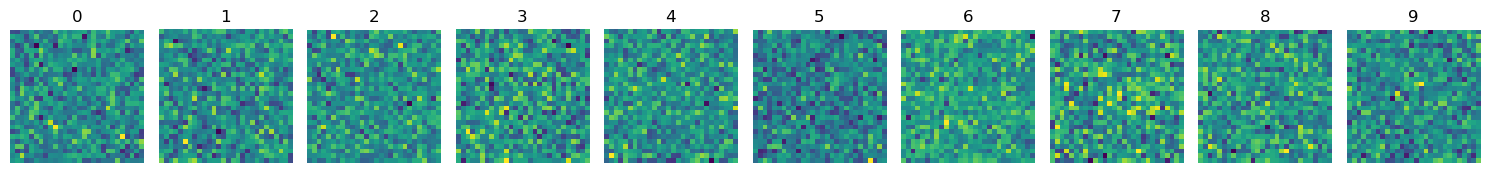

Iteration 4000 current batch loss: 0.0013701096177101135
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999576, 0.999615, 0.999436, 0.999848, 0.999236, 0.999978, 0.999588, 0.999724, 0.999575, 0.999611]


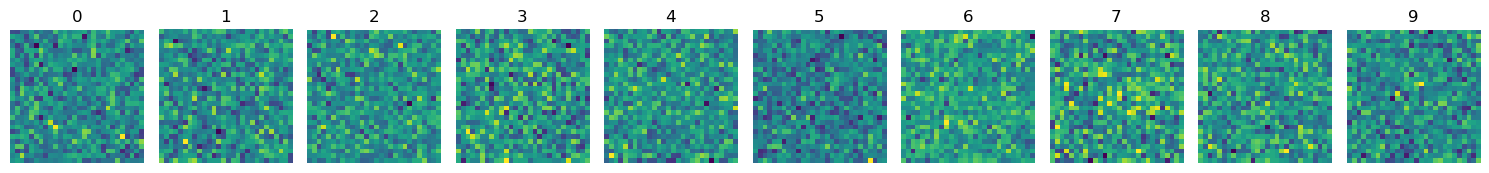

Iteration 6000 current batch loss: 0.0011005632113665342
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99985, 0.999871, 0.999818, 0.99995, 0.99973, 0.99999, 0.999854, 0.999906, 0.999852, 0.999872]


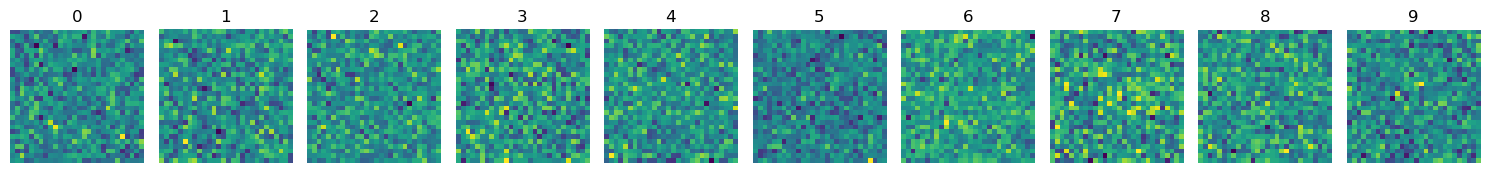

Iteration 8000 current batch loss: 0.0009782561101019382
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999944, 0.999953, 0.999934, 0.999981, 0.999896, 0.999994, 0.999943, 0.999962, 0.999942, 0.999951]


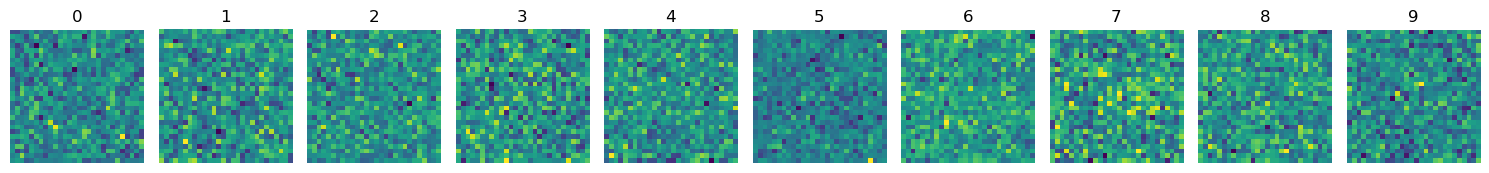

Iteration 10000 current batch loss: 0.0008696435252204537
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999977, 0.999981, 0.999972, 0.999991, 0.999959, 0.999995, 0.999976, 0.999983, 0.999973, 0.999977]


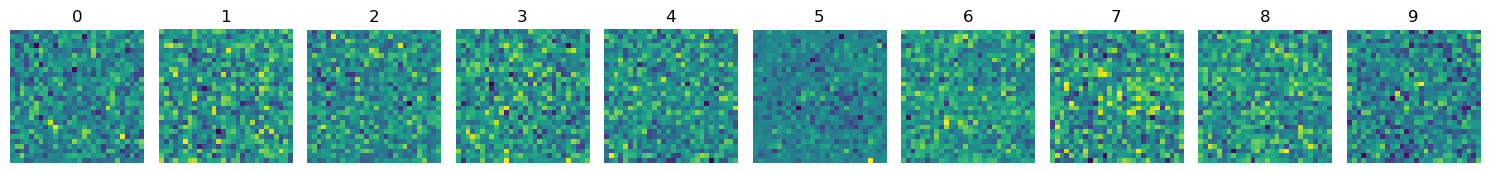

Iteration 12000 current batch loss: 0.0007192972116172314
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999988, 0.999989, 0.999985, 0.999995, 0.999981, 0.999996, 0.999987, 0.99999, 0.999983, 0.999986]


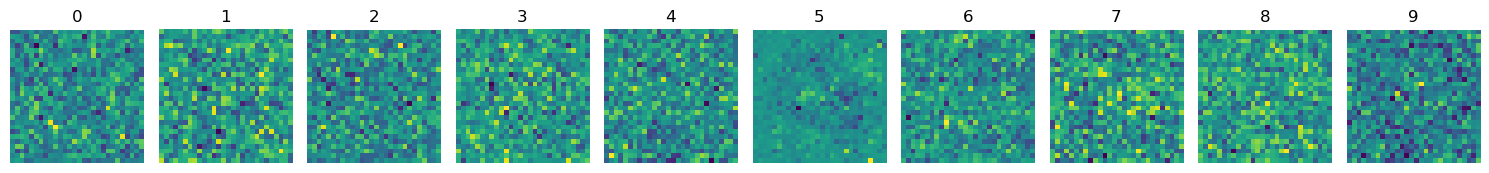

Iteration 14000 current batch loss: 0.0005040887044742703
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999991, 0.999992, 0.99999, 0.999996, 0.999988, 0.999996, 0.99999, 0.999993, 0.999987, 0.99999]


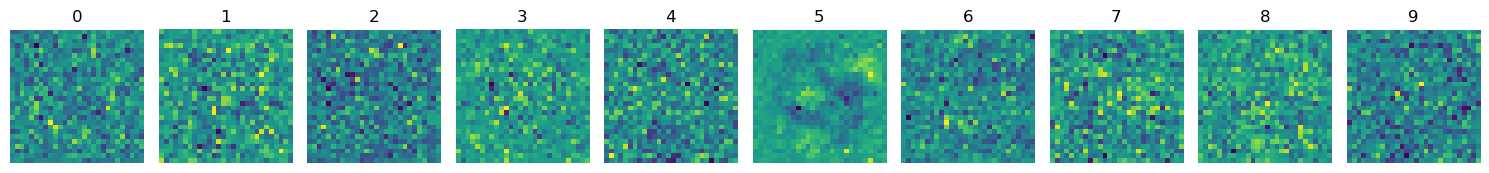

Iteration 16000 current batch loss: 0.00026939078816212714
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999993, 0.999992, 0.999992, 0.999996, 0.999992, 0.999996, 0.999992, 0.999994, 0.99999, 0.999992]


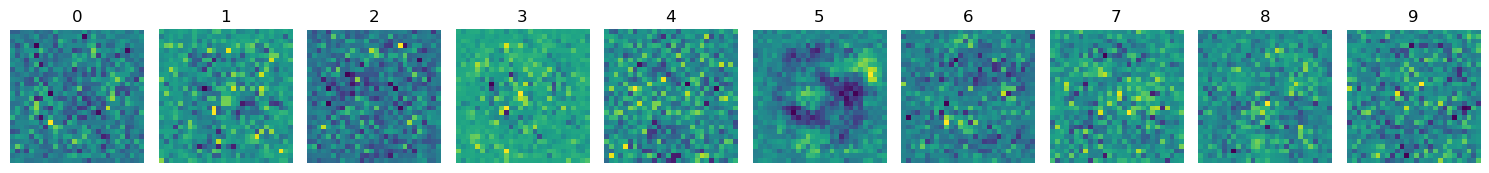

Iteration 16056 current batch loss: 0.00026347560924477875


In [14]:
points_2 = train_input(net, lambda_l2 = 0.001, plot = True)

# Case: $\lambda = 0.01$

Iteration 2000 current batch loss: 0.011170086450874805
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997869, 0.998566, 0.998344, 0.998899, 0.99805, 0.999927, 0.998455, 0.998903, 0.997762, 0.997671]


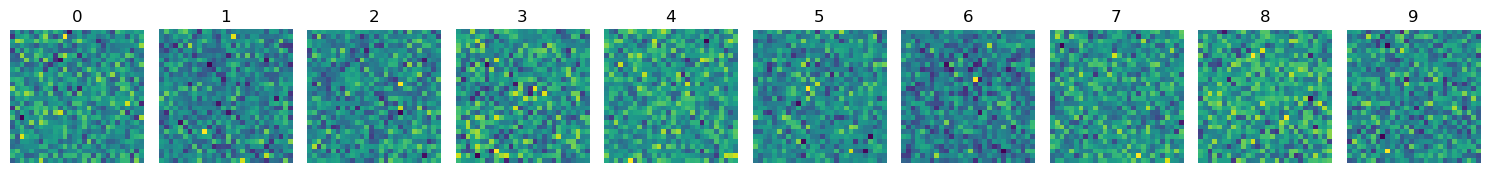

Iteration 4000 current batch loss: 0.009374290704727173
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999482, 0.999673, 0.999524, 0.999717, 0.999474, 0.999954, 0.999599, 0.999729, 0.999435, 0.999408]


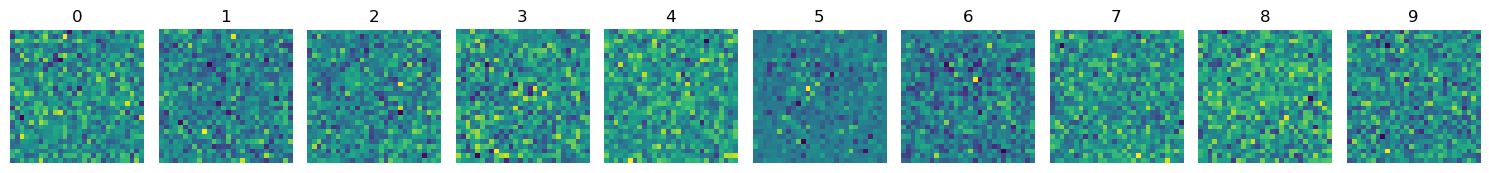

Iteration 6000 current batch loss: 0.008267735131084919
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999803, 0.999861, 0.999794, 0.999884, 0.999789, 0.999965, 0.999831, 0.999894, 0.999771, 0.999768]


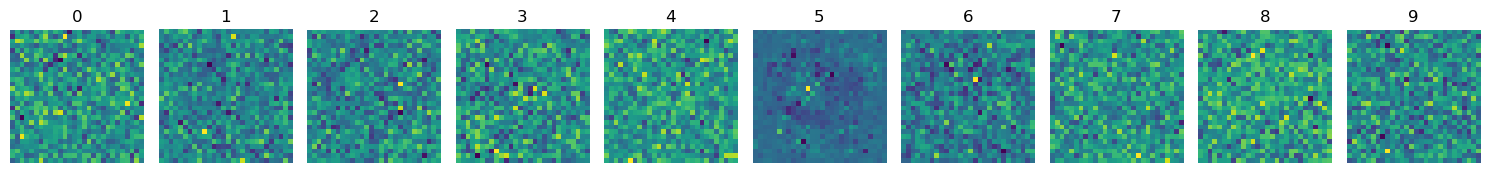

Iteration 8000 current batch loss: 0.006664902437478304
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999897, 0.999905, 0.999872, 0.999925, 0.999895, 0.999969, 0.999902, 0.99994, 0.999864, 0.999884]


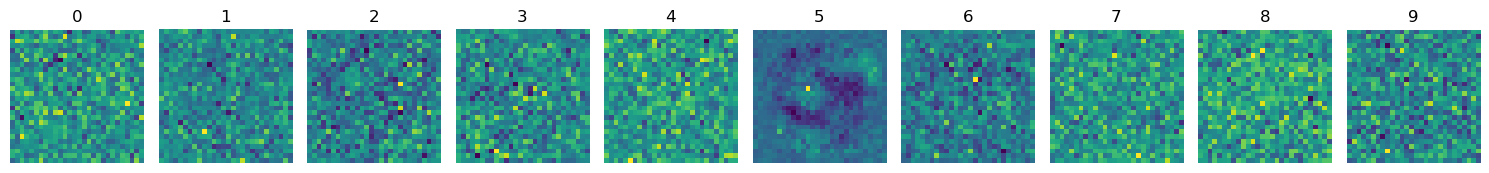

Iteration 10000 current batch loss: 0.004332514945417643
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999924, 0.999923, 0.999901, 0.999943, 0.999922, 0.99997, 0.999923, 0.999957, 0.9999, 0.999912]


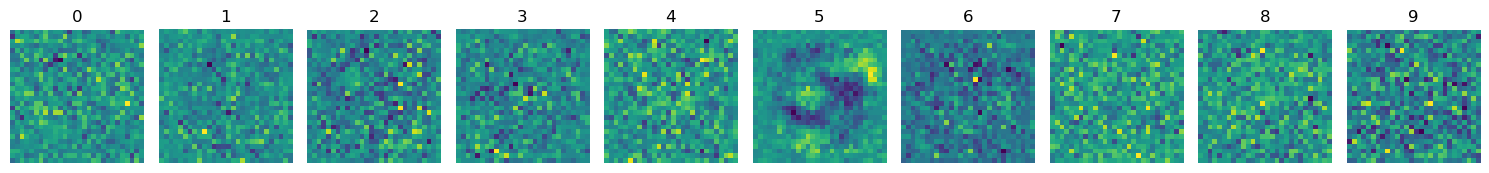

Iteration 12000 current batch loss: 0.002002769848331809
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999938, 0.999937, 0.999927, 0.999961, 0.999937, 0.99997, 0.999934, 0.999967, 0.999917, 0.999939]


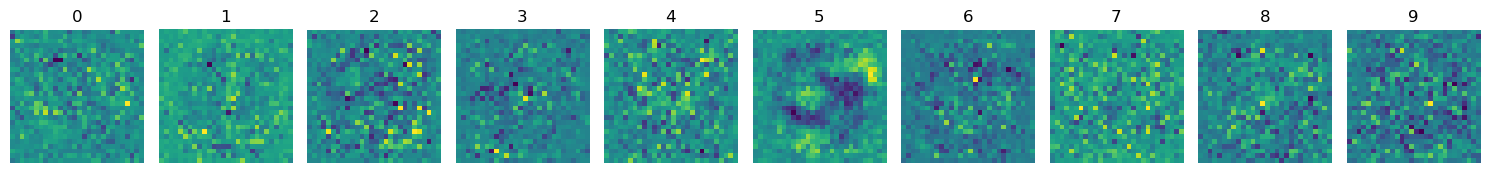

Iteration 14000 current batch loss: 0.000670732231810689
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999949, 0.999942, 0.999952, 0.999967, 0.999947, 0.99997, 0.99994, 0.999974, 0.999928, 0.999955]


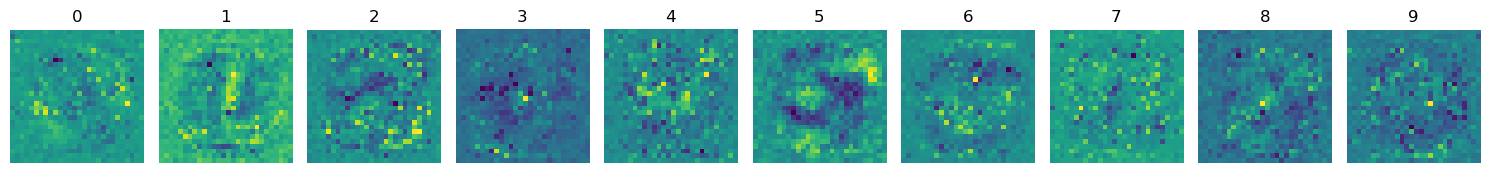

Iteration 16000 current batch loss: 0.0003270673914812505
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999953, 0.999944, 0.999959, 0.999968, 0.999952, 0.99997, 0.999942, 0.999975, 0.999931, 0.999958]


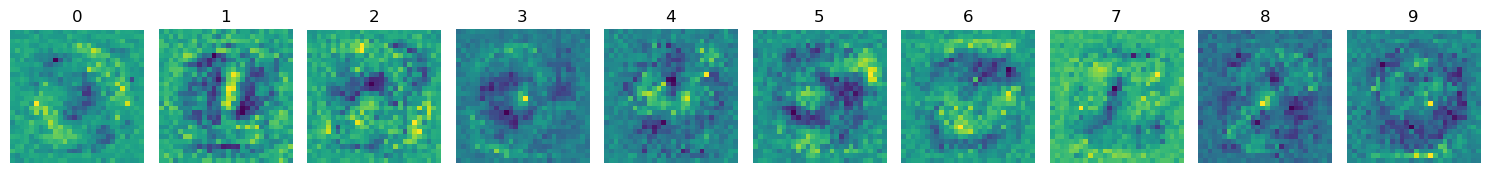

Iteration 18000 current batch loss: 0.00030039361445233226
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999944, 0.999961, 0.999968, 0.999953, 0.99997, 0.999943, 0.999975, 0.999932, 0.999959]


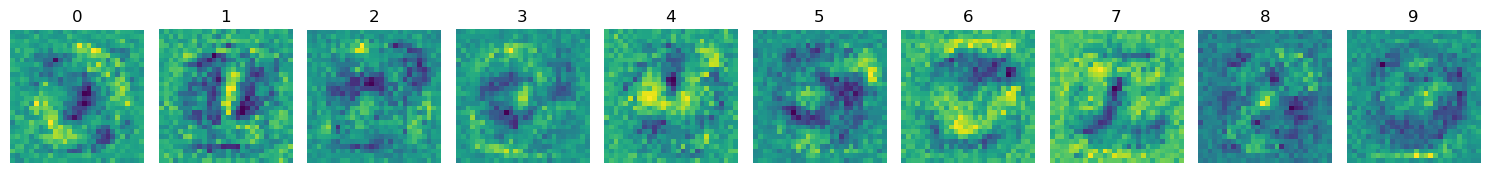

Iteration 20000 current batch loss: 0.0003000569122377783
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999944, 0.999961, 0.999968, 0.999954, 0.99997, 0.999944, 0.999974, 0.999932, 0.999959]


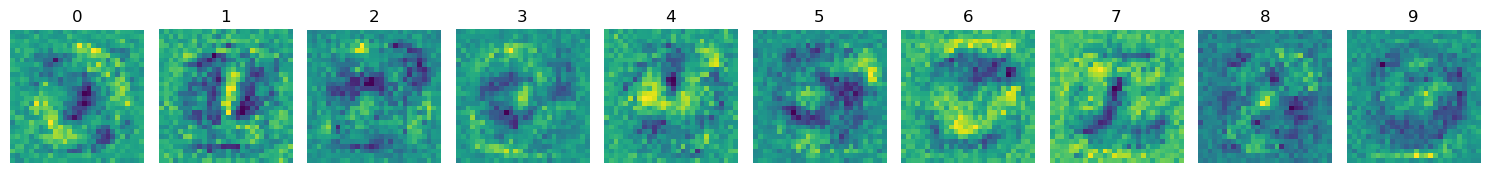

Iteration 22000 current batch loss: 0.00030008575413376093
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999944, 0.999961, 0.999968, 0.999954, 0.99997, 0.999943, 0.999974, 0.999932, 0.999959]


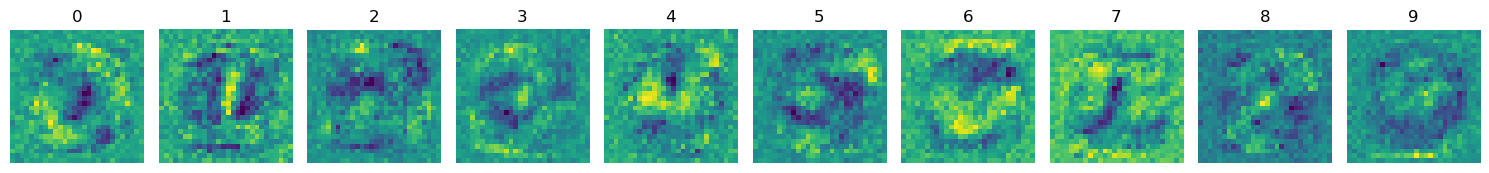

Iteration 24000 current batch loss: 0.0003000858996529132
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999944, 0.999961, 0.999968, 0.999954, 0.99997, 0.999944, 0.999974, 0.999932, 0.999959]


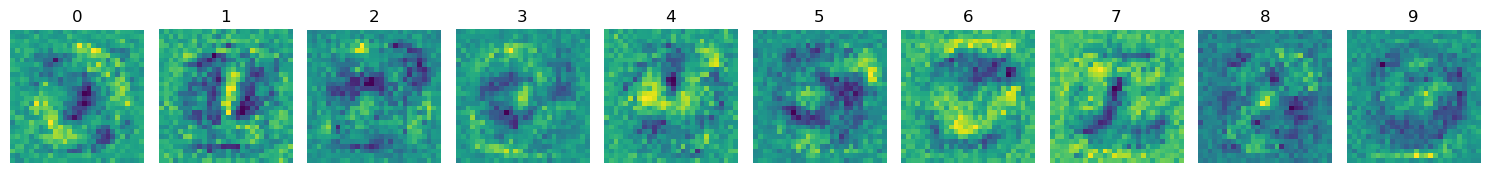

Iteration 26000 current batch loss: 0.00030009972397238016
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999944, 0.999961, 0.999968, 0.999954, 0.99997, 0.999944, 0.999974, 0.999932, 0.999959]


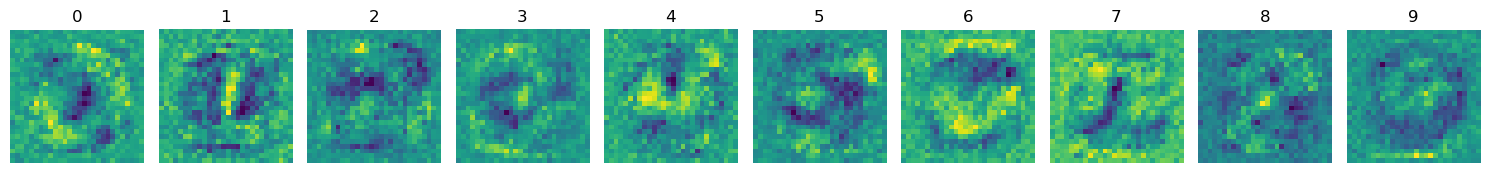

Iteration 28000 current batch loss: 0.0003001155855599791
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999944, 0.999961, 0.999968, 0.999954, 0.99997, 0.999944, 0.999974, 0.999932, 0.999959]


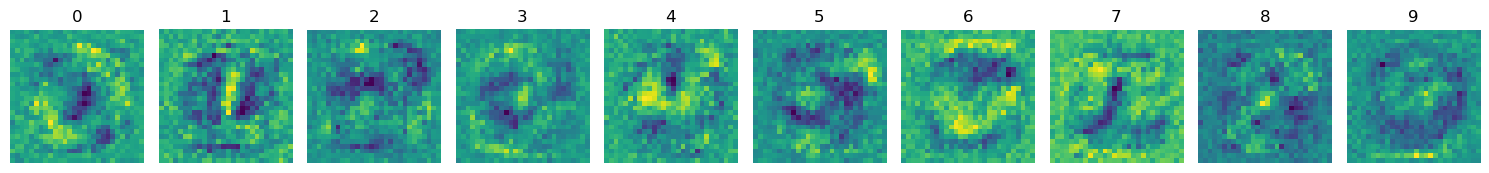

Iteration 30000 current batch loss: 0.00030012032948434353
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999944, 0.999961, 0.999968, 0.999954, 0.99997, 0.999944, 0.999974, 0.999932, 0.999959]


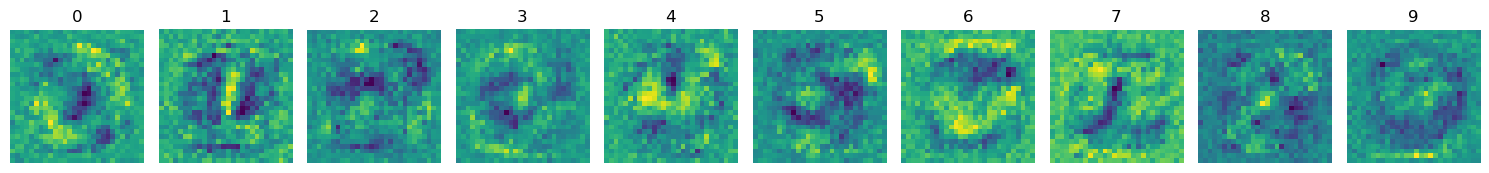

Iteration 32000 current batch loss: 0.00030010956106707454
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999944, 0.999961, 0.999968, 0.999954, 0.99997, 0.999944, 0.999974, 0.999932, 0.999959]


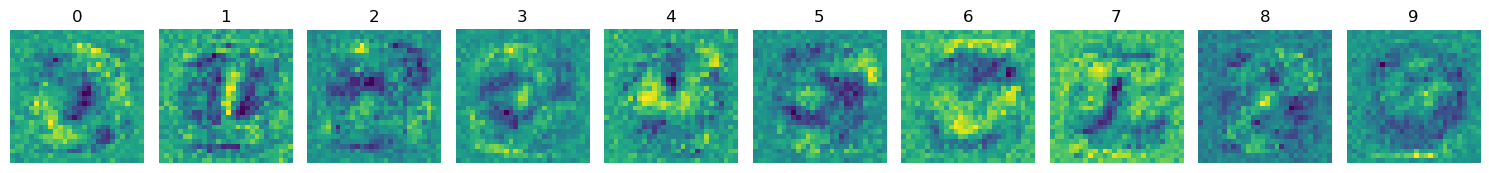

Iteration 34000 current batch loss: 0.00030011424678377807
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999944, 0.999961, 0.999968, 0.999954, 0.99997, 0.999943, 0.999974, 0.999932, 0.999959]


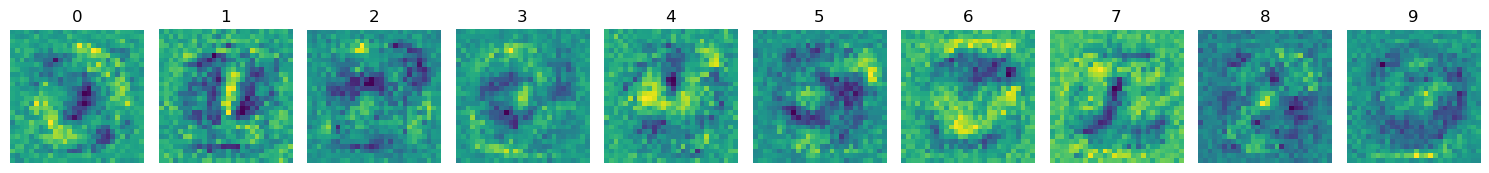

Iteration 36000 current batch loss: 0.00030011608032509685
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999944, 0.999961, 0.999968, 0.999954, 0.99997, 0.999944, 0.999974, 0.999932, 0.999959]


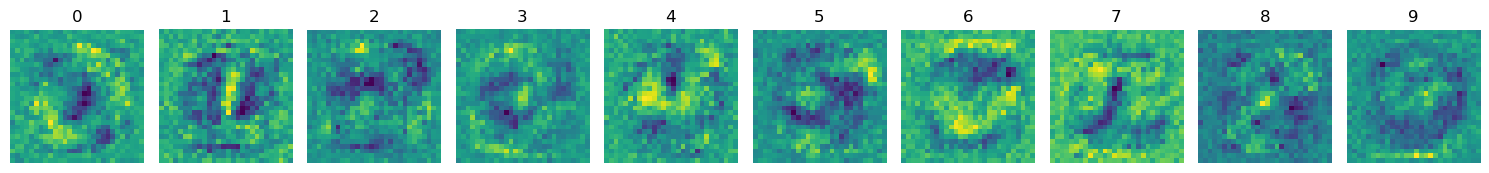

Iteration 38000 current batch loss: 0.00030014183721505105
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999944, 0.999961, 0.999968, 0.999954, 0.999969, 0.999944, 0.999974, 0.999932, 0.999959]


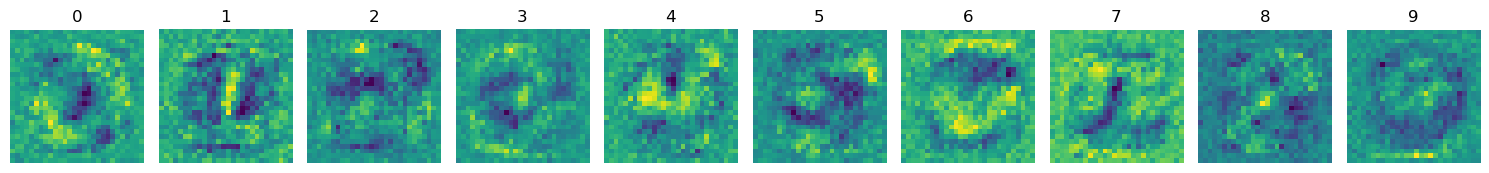

Iteration 40000 current batch loss: 0.00030010059708729386
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999954, 0.999944, 0.999961, 0.999968, 0.999954, 0.99997, 0.999944, 0.999974, 0.999932, 0.999959]


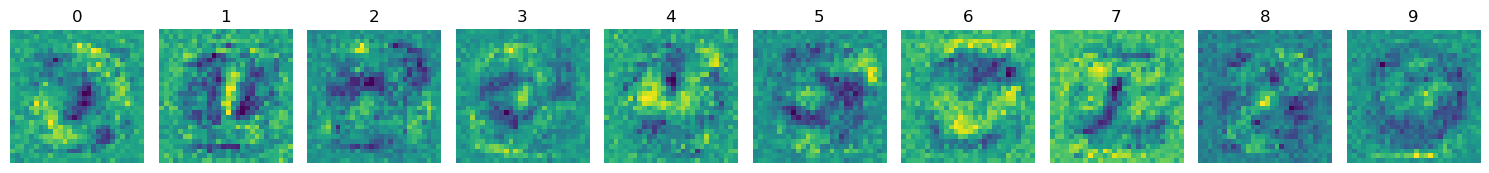

Iteration 40000 current batch loss: 0.00030010059708729386


In [15]:
points_3 = train_input(net, lambda_l2 = 0.01, plot = True)

# Case: $\lambda = 0.1$

Iteration 2000 current batch loss: 0.08644471317529678
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.998285, 0.998019, 0.998329, 0.999605, 0.997328, 0.999319, 0.997658, 0.999088, 0.998041, 0.997658]


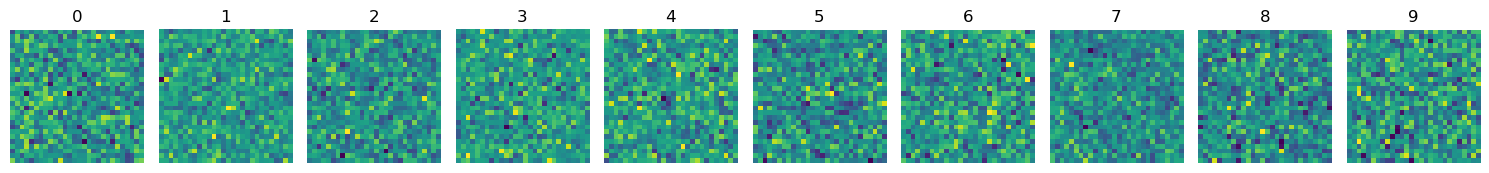

Iteration 4000 current batch loss: 0.06248672306537628
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999385, 0.999281, 0.999286, 0.999684, 0.99894, 0.999569, 0.999197, 0.999577, 0.999119, 0.999199]


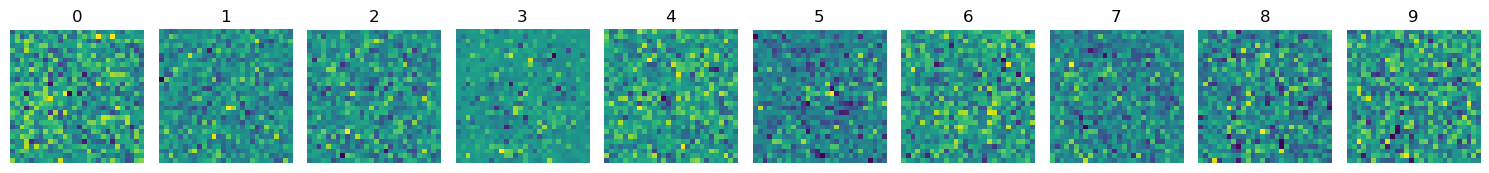

Iteration 6000 current batch loss: 0.03608931601047516
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99952, 0.999451, 0.999467, 0.999736, 0.999294, 0.99969, 0.999483, 0.999653, 0.999193, 0.999548]


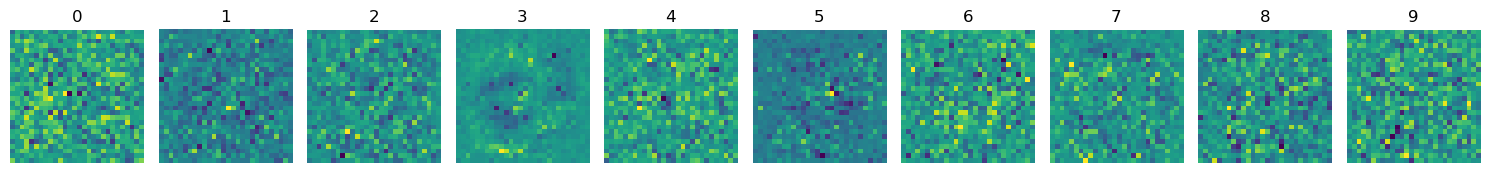

Iteration 8000 current batch loss: 0.014760705642402172
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999548, 0.999506, 0.999624, 0.999736, 0.999496, 0.999738, 0.999522, 0.999752, 0.999254, 0.999581]


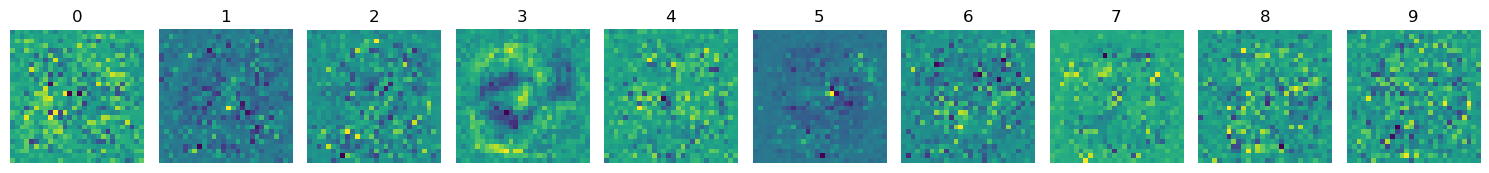

Iteration 10000 current batch loss: 0.004544115625321865
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999588, 0.999532, 0.999668, 0.999736, 0.999581, 0.99975, 0.999541, 0.999786, 0.999386, 0.999648]


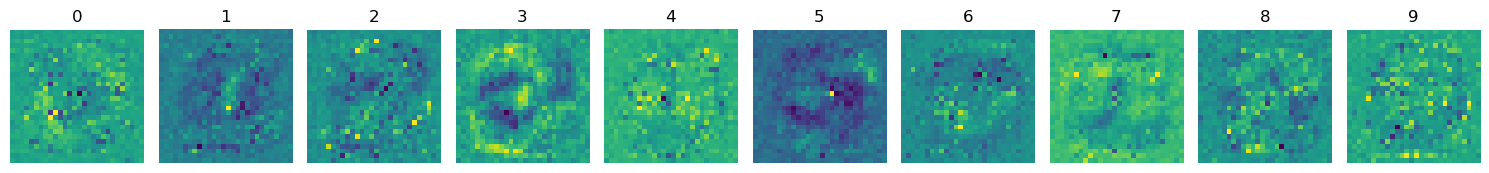

Iteration 12000 current batch loss: 0.002244457369670272
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99962, 0.999548, 0.99968, 0.999736, 0.999616, 0.999753, 0.999538, 0.999791, 0.999434, 0.999665]


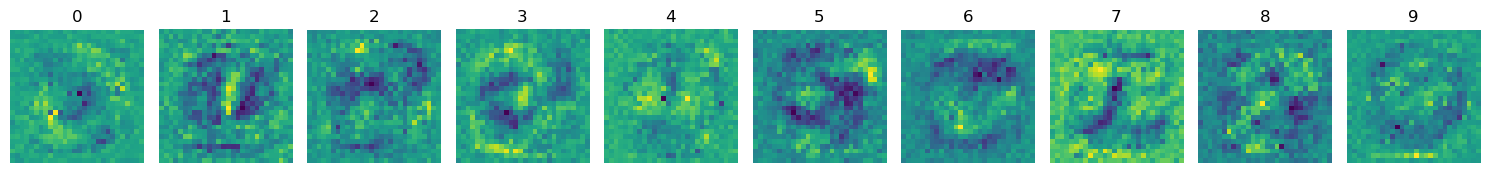

Iteration 14000 current batch loss: 0.0020756456069648266
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999629, 0.999549, 0.99968, 0.999736, 0.999631, 0.999753, 0.999544, 0.999791, 0.999448, 0.999663]


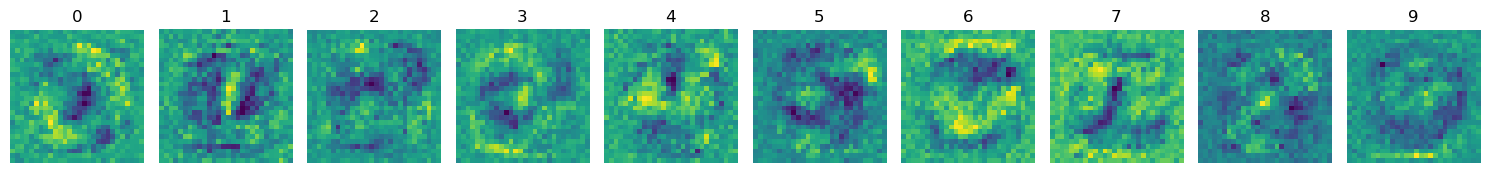

Iteration 16000 current batch loss: 0.002073936862871051
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99963, 0.99955, 0.99968, 0.999736, 0.999632, 0.999754, 0.999544, 0.999791, 0.999449, 0.999662]


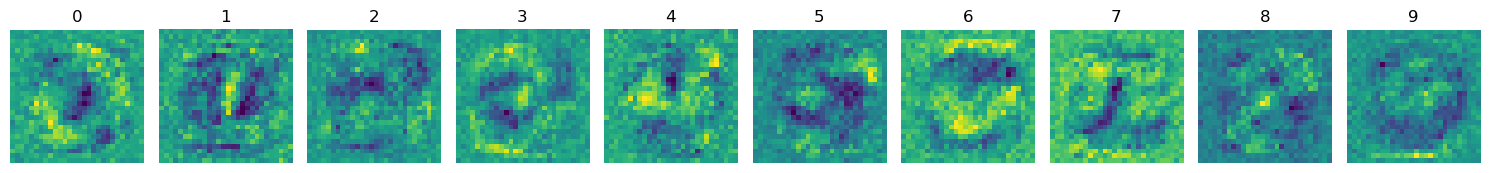

Iteration 18000 current batch loss: 0.0020739815663546324
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99963, 0.999549, 0.99968, 0.999736, 0.999632, 0.999754, 0.999544, 0.999791, 0.999449, 0.999663]


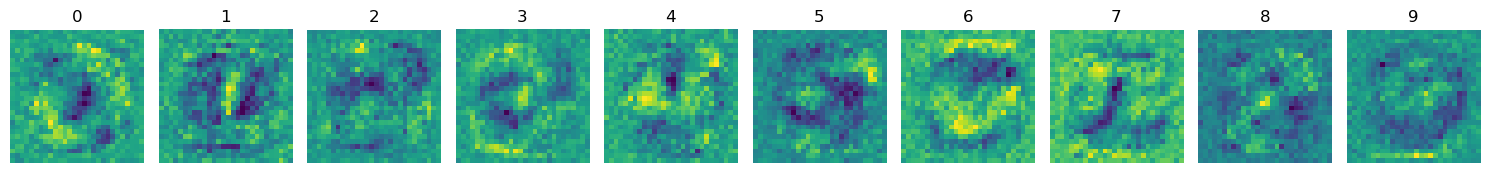

Iteration 20000 current batch loss: 0.0020739666651934385
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99963, 0.99955, 0.999681, 0.999735, 0.999631, 0.999754, 0.999544, 0.999791, 0.99945, 0.999663]


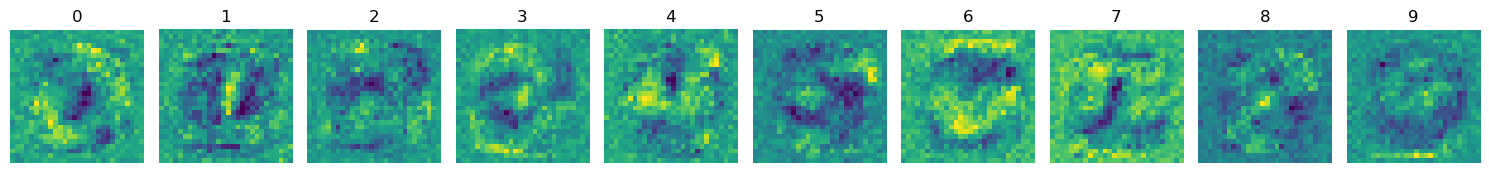

Iteration 22000 current batch loss: 0.0020740306936204433
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99963, 0.999549, 0.99968, 0.999735, 0.999632, 0.999754, 0.999544, 0.999791, 0.99945, 0.999662]


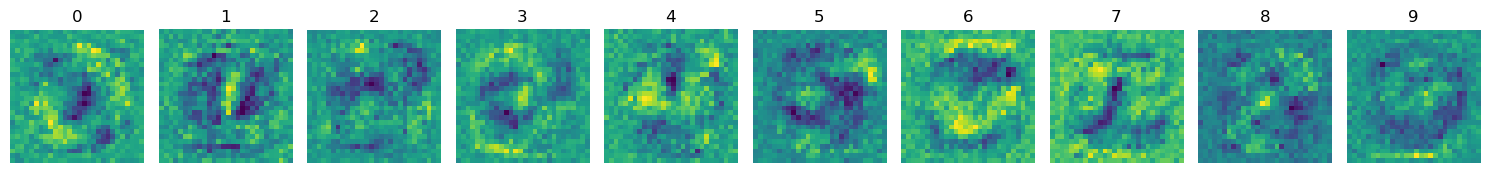

Iteration 24000 current batch loss: 0.002073989948257804
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99963, 0.999549, 0.99968, 0.999735, 0.999632, 0.999753, 0.999544, 0.999791, 0.999449, 0.999663]


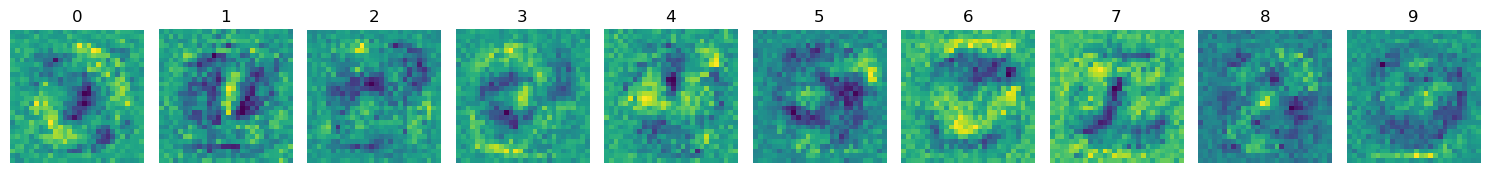

Iteration 26000 current batch loss: 0.0020740246400237083
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99963, 0.999549, 0.999681, 0.999735, 0.999632, 0.999753, 0.999544, 0.999791, 0.999449, 0.999663]


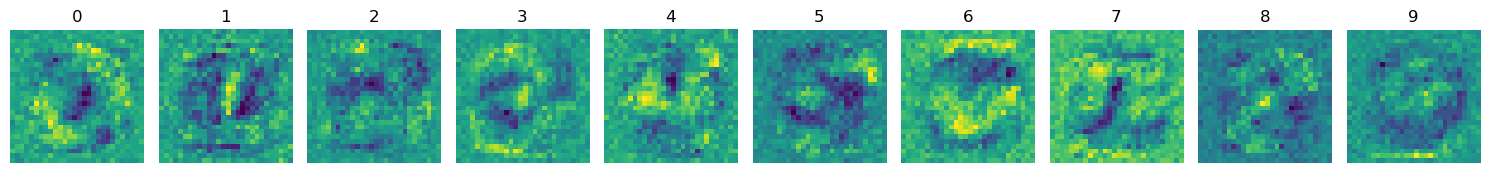

Iteration 28000 current batch loss: 0.0020740118343383074
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99963, 0.999549, 0.99968, 0.999735, 0.999632, 0.999754, 0.999544, 0.999792, 0.999449, 0.999663]


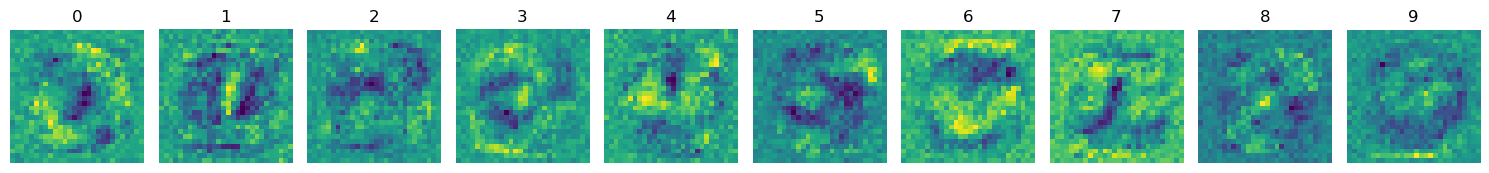

Iteration 30000 current batch loss: 0.002073996001854539
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999629, 0.999549, 0.99968, 0.999735, 0.999632, 0.999753, 0.999544, 0.999791, 0.999449, 0.999663]


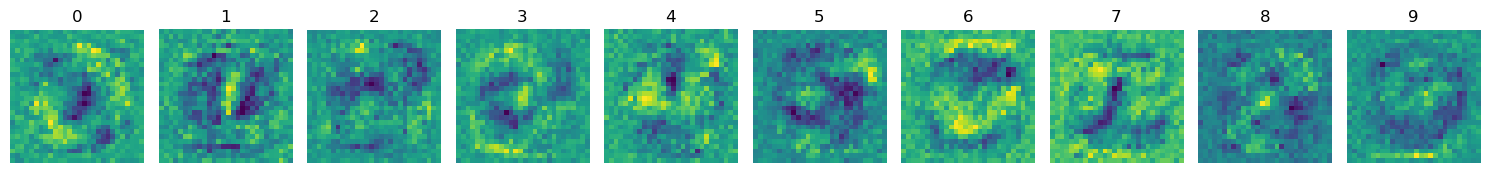

Iteration 32000 current batch loss: 0.0020739214960485697
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99963, 0.999549, 0.99968, 0.999735, 0.999632, 0.999754, 0.999544, 0.999791, 0.999449, 0.999663]


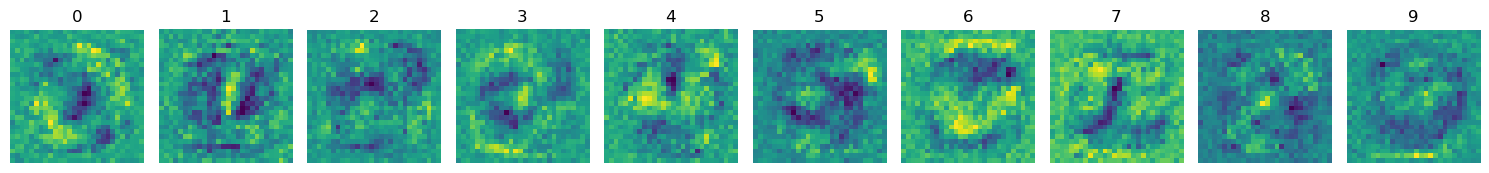

Iteration 34000 current batch loss: 0.002074010204523802
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99963, 0.999549, 0.99968, 0.999735, 0.999632, 0.999754, 0.999544, 0.999791, 0.999449, 0.999662]


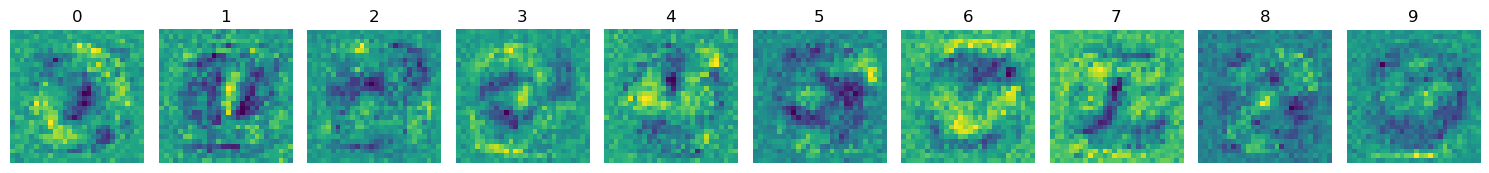

Iteration 36000 current batch loss: 0.002073931973427534
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999629, 0.999549, 0.999681, 0.999736, 0.999632, 0.999754, 0.999544, 0.999791, 0.99945, 0.999663]


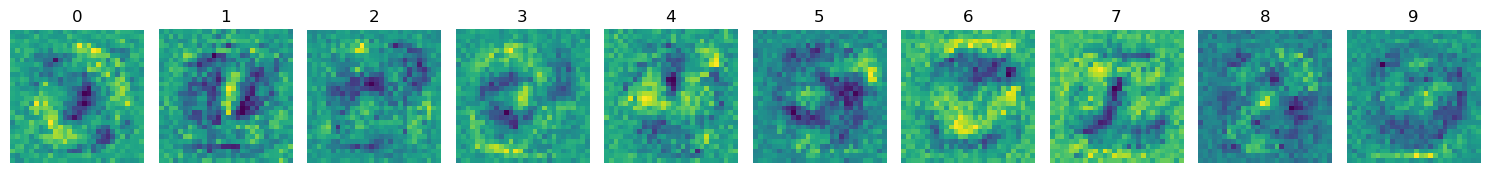

Iteration 38000 current batch loss: 0.0020740185864269733
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99963, 0.999549, 0.99968, 0.999735, 0.999632, 0.999753, 0.999544, 0.999791, 0.999449, 0.999663]


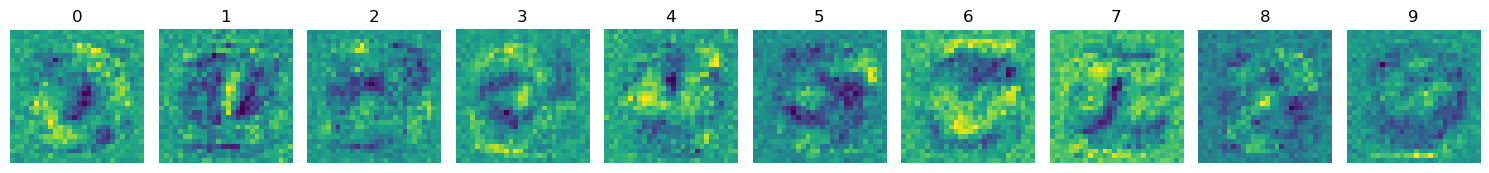

Iteration 40000 current batch loss: 0.002074002055451274
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99963, 0.999549, 0.99968, 0.999735, 0.999632, 0.999754, 0.999544, 0.999791, 0.99945, 0.999663]


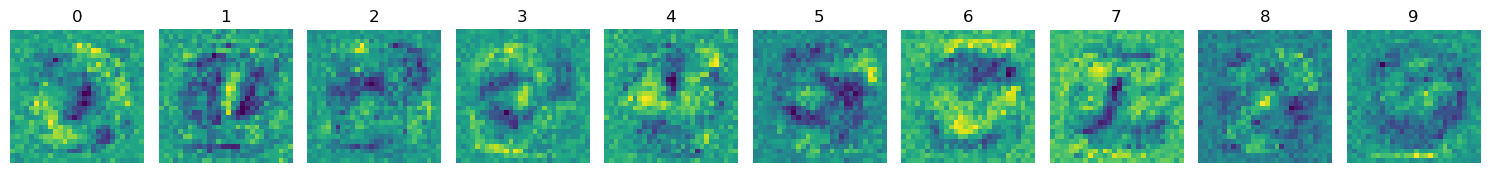

Iteration 40000 current batch loss: 0.002074002055451274


In [16]:
points_4 = train_input(net, lambda_l2 = 0.1, plot = True)

# Case: $\lambda = 1$

Iteration 2000 current batch loss: 0.4271150529384613
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.993962, 0.993555, 0.997354, 0.995474, 0.995502, 0.996918, 0.99293, 0.99721, 0.994319, 0.996084]


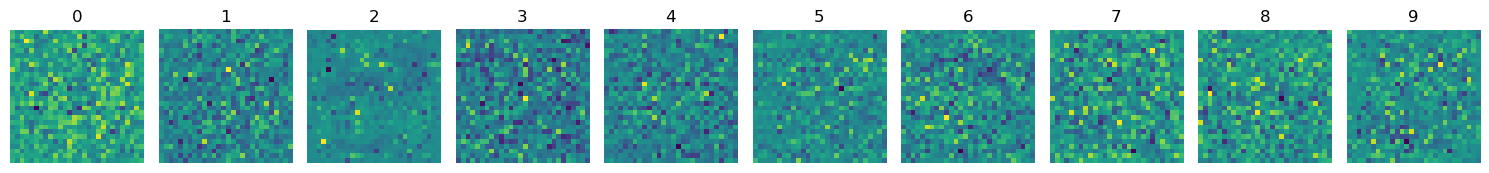

Iteration 4000 current batch loss: 0.1164434403181076
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99593, 0.995506, 0.997509, 0.996679, 0.99645, 0.997726, 0.99529, 0.997854, 0.994733, 0.997145]


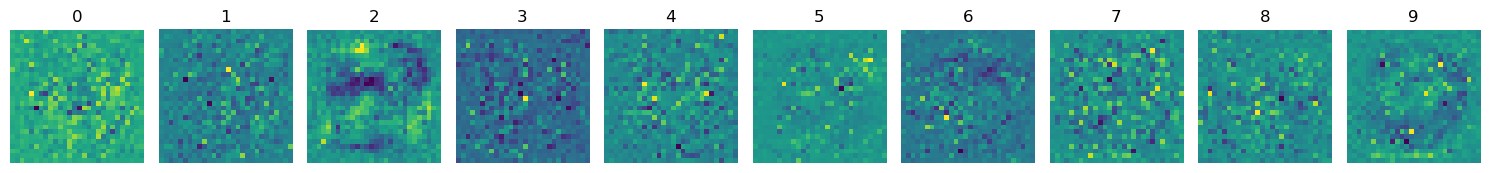

Iteration 6000 current batch loss: 0.025517351925373077
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997021, 0.996431, 0.997535, 0.997677, 0.996994, 0.99805, 0.996251, 0.998288, 0.995414, 0.997335]


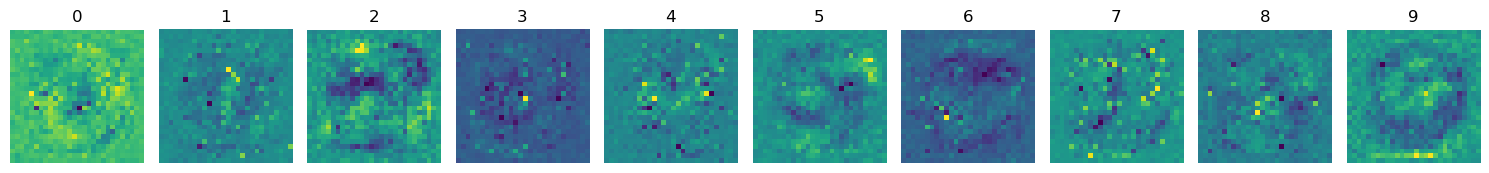

Iteration 8000 current batch loss: 0.013793890364468098
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997131, 0.996521, 0.997536, 0.997897, 0.997056, 0.998067, 0.996445, 0.998352, 0.995732, 0.997345]


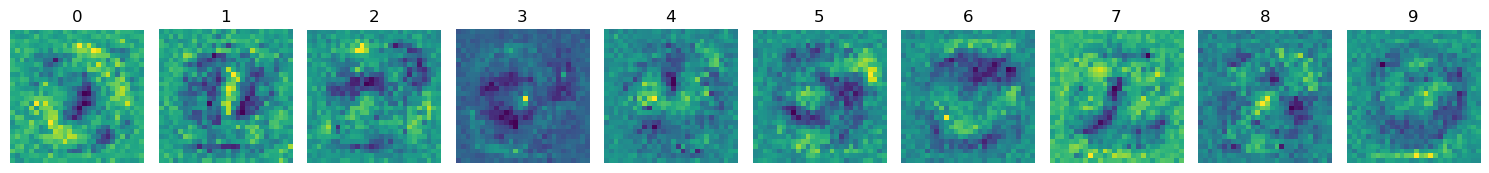

Iteration 10000 current batch loss: 0.013431633822619915
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99714, 0.996504, 0.997536, 0.997915, 0.997083, 0.998067, 0.996463, 0.998361, 0.995784, 0.997344]


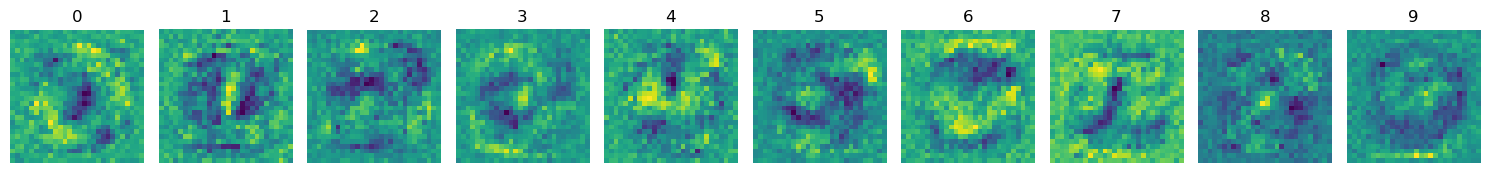

Iteration 12000 current batch loss: 0.013431400060653687
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99714, 0.996504, 0.997539, 0.997914, 0.997084, 0.998068, 0.996461, 0.998361, 0.995784, 0.997343]


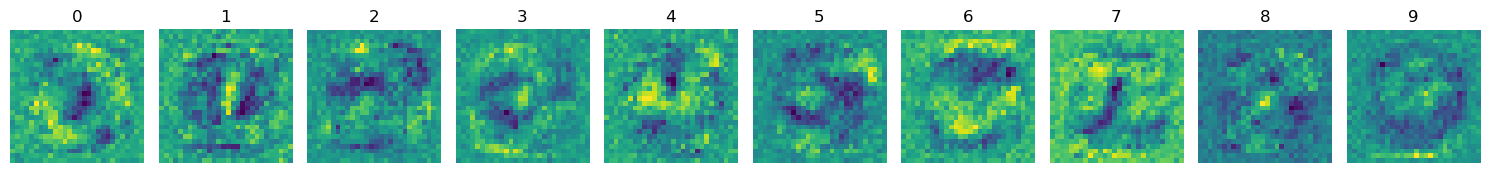

Iteration 14000 current batch loss: 0.013431988656520844
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997139, 0.996502, 0.997535, 0.997914, 0.997083, 0.998069, 0.996458, 0.998362, 0.995785, 0.997346]


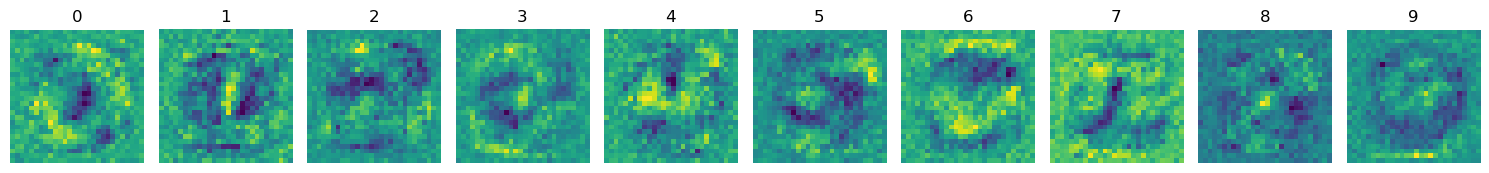

Iteration 16000 current batch loss: 0.013432348147034645
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997139, 0.996506, 0.997536, 0.997913, 0.997083, 0.998068, 0.996461, 0.998361, 0.995787, 0.997344]


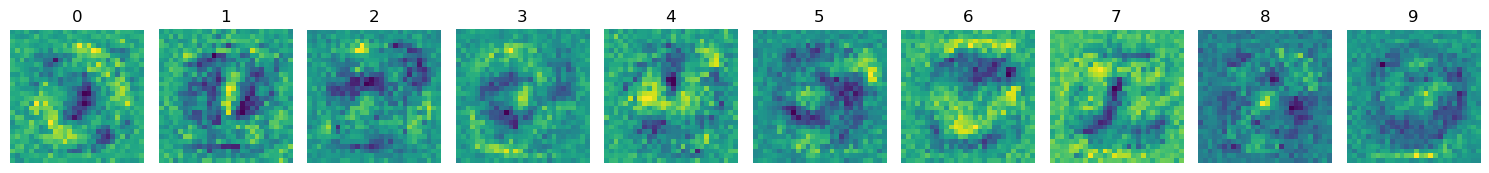

Iteration 18000 current batch loss: 0.013432567939162254
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997139, 0.996505, 0.997536, 0.997911, 0.997085, 0.998067, 0.996461, 0.998361, 0.995789, 0.997345]


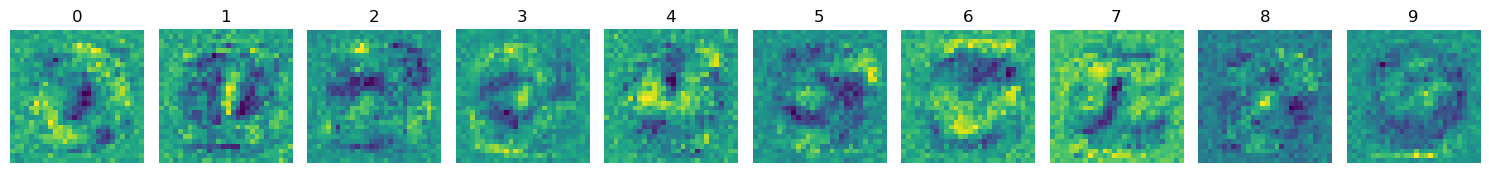

Iteration 20000 current batch loss: 0.013432980515062809
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99714, 0.996506, 0.997537, 0.997912, 0.997085, 0.998068, 0.996461, 0.998361, 0.995786, 0.997346]


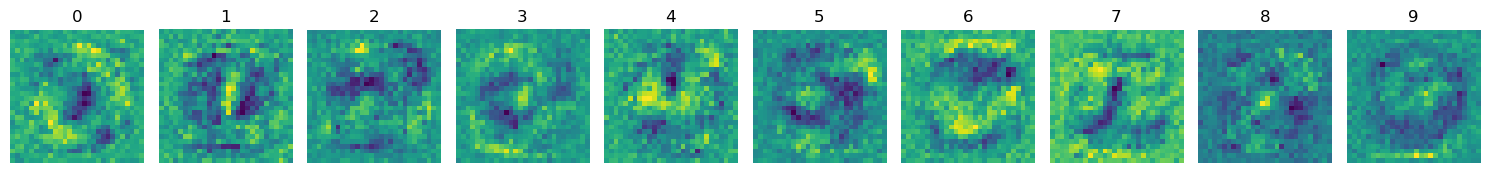

Iteration 22000 current batch loss: 0.013432737439870834
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99714, 0.996502, 0.997539, 0.997913, 0.997083, 0.998067, 0.996462, 0.99836, 0.995783, 0.997345]


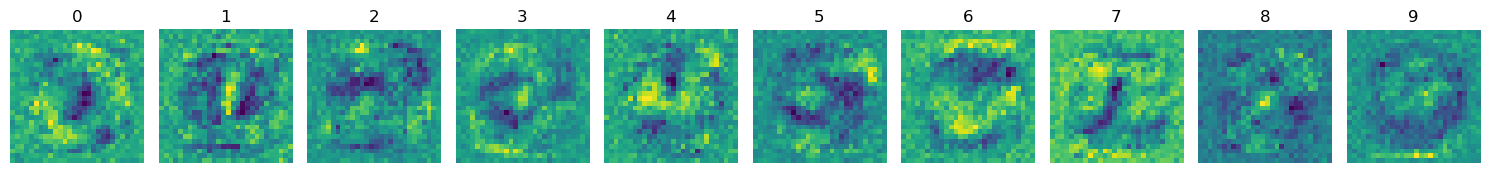

Iteration 24000 current batch loss: 0.013432370498776436
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997138, 0.996503, 0.997537, 0.997914, 0.997083, 0.998066, 0.996462, 0.998361, 0.995786, 0.997345]


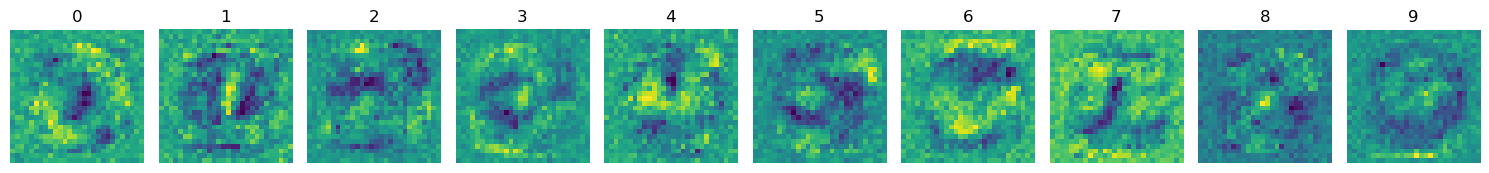

Iteration 26000 current batch loss: 0.013432253152132034
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99714, 0.996505, 0.997539, 0.997914, 0.997091, 0.998068, 0.996462, 0.998361, 0.995785, 0.997344]


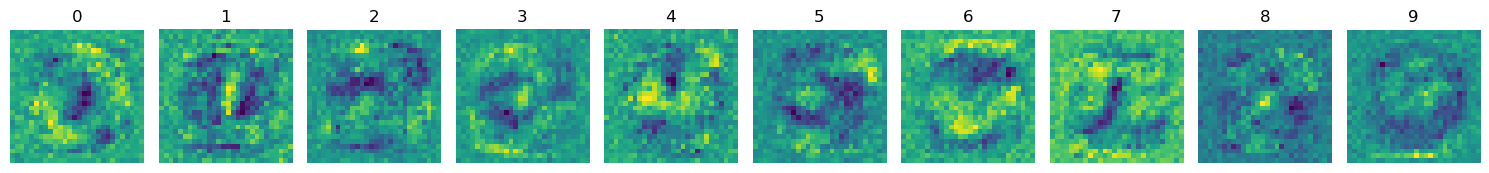

Iteration 28000 current batch loss: 0.0134328193962574
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997138, 0.996503, 0.997538, 0.997914, 0.997085, 0.998068, 0.996463, 0.998363, 0.995789, 0.997344]


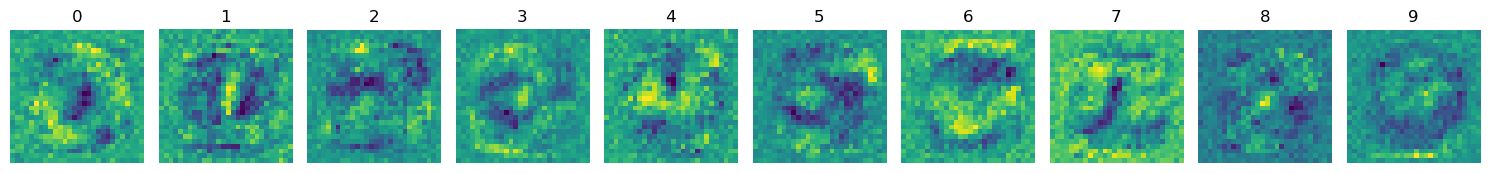

Iteration 30000 current batch loss: 0.013432567939162254
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997141, 0.996506, 0.997536, 0.997913, 0.997085, 0.998067, 0.996463, 0.998361, 0.995784, 0.997344]


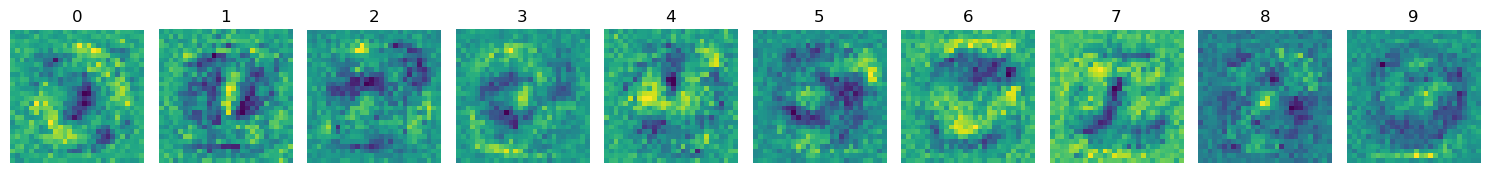

Iteration 32000 current batch loss: 0.013432774692773819
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997139, 0.996502, 0.997534, 0.997914, 0.997082, 0.998065, 0.996461, 0.998361, 0.995787, 0.997344]


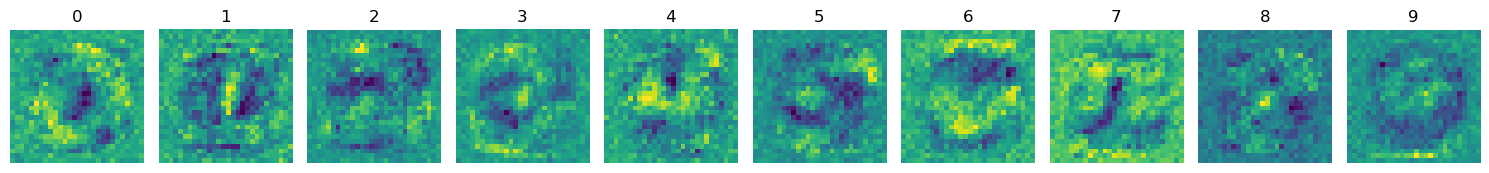

Iteration 34000 current batch loss: 0.013432592153549194
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997139, 0.996504, 0.997534, 0.997914, 0.997086, 0.998067, 0.996461, 0.99836, 0.995785, 0.997345]


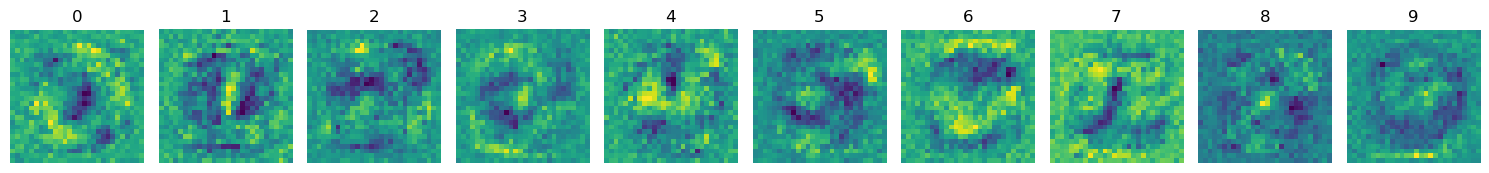

Iteration 36000 current batch loss: 0.013432593084871769
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997139, 0.996502, 0.997535, 0.997913, 0.997084, 0.998068, 0.996462, 0.998362, 0.995788, 0.997345]


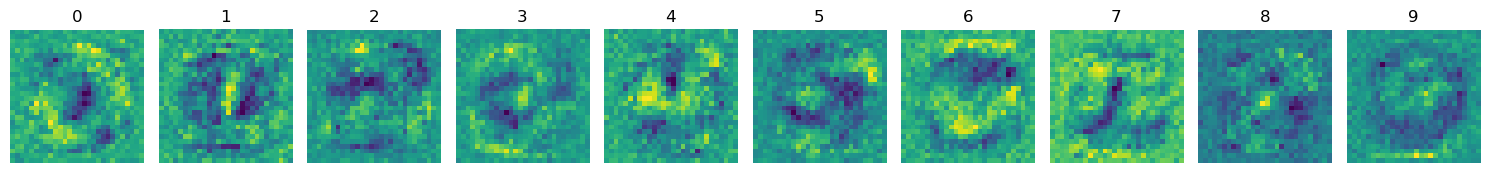

Iteration 38000 current batch loss: 0.013432590290904045
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997138, 0.996507, 0.997535, 0.997914, 0.997086, 0.998068, 0.996462, 0.998361, 0.995786, 0.997343]


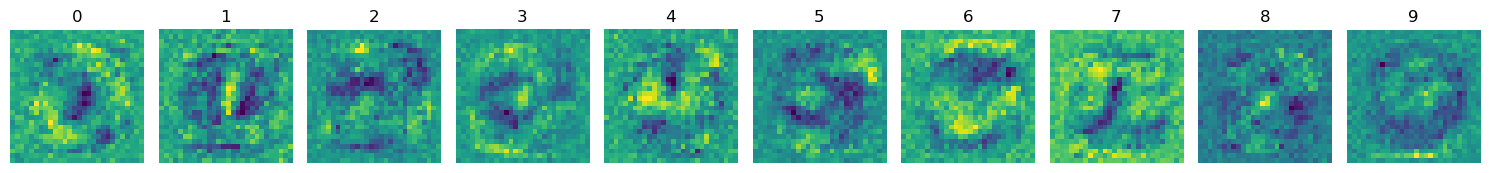

Iteration 40000 current batch loss: 0.013432180508971214
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99714, 0.996506, 0.997535, 0.997914, 0.997087, 0.998068, 0.996461, 0.99836, 0.99579, 0.997345]


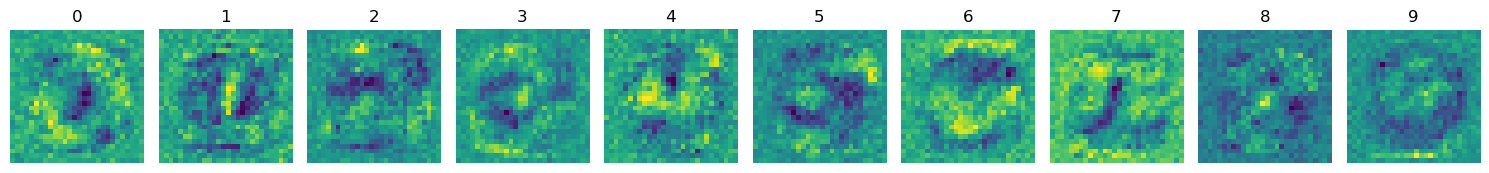

Iteration 40000 current batch loss: 0.013432180508971214


In [17]:
points_5 = train_input(net, lambda_l2 = 1, plot = True)

# Case: $\lambda = 10$

Iteration 2000 current batch loss: 0.8093849420547485
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.974381, 0.968941, 0.975491, 0.981527, 0.963928, 0.980977, 0.967616, 0.985656, 0.952533, 0.974161]


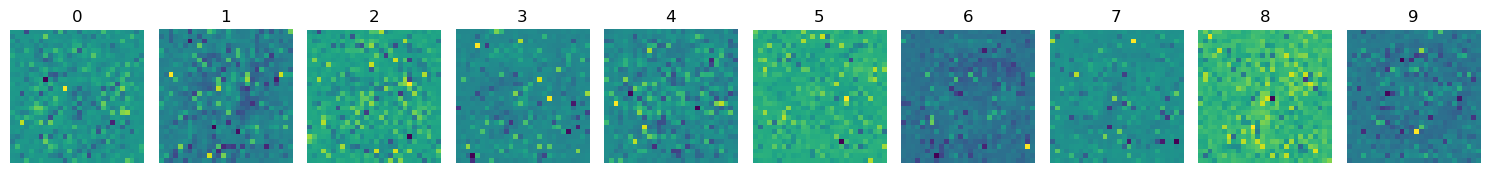

Iteration 4000 current batch loss: 0.09734180569648743
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.978825, 0.97419, 0.981077, 0.984281, 0.977151, 0.985383, 0.974046, 0.987779, 0.967739, 0.979701]


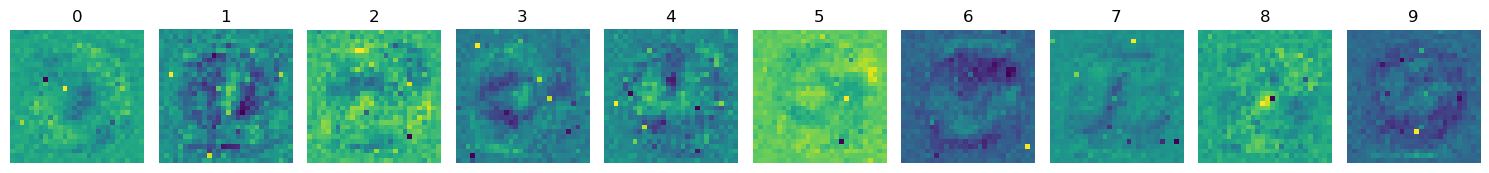

Iteration 6000 current batch loss: 0.07891345024108887
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979421, 0.974593, 0.981959, 0.984697, 0.978793, 0.985713, 0.974541, 0.987813, 0.969454, 0.980478]


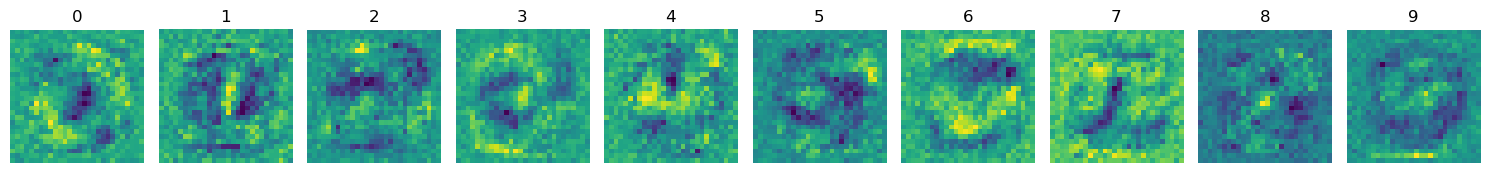

Iteration 8000 current batch loss: 0.07879413664340973
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979458, 0.974593, 0.981982, 0.984697, 0.978867, 0.985751, 0.974539, 0.987798, 0.969536, 0.980559]


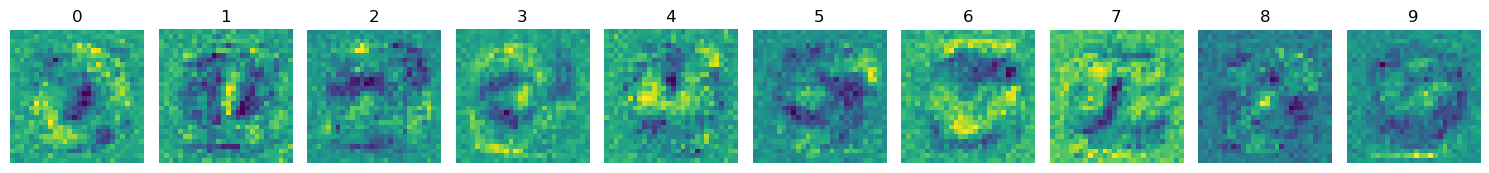

Iteration 10000 current batch loss: 0.07879890501499176
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979453, 0.97459, 0.981977, 0.984698, 0.978878, 0.985742, 0.974535, 0.987788, 0.969572, 0.980569]


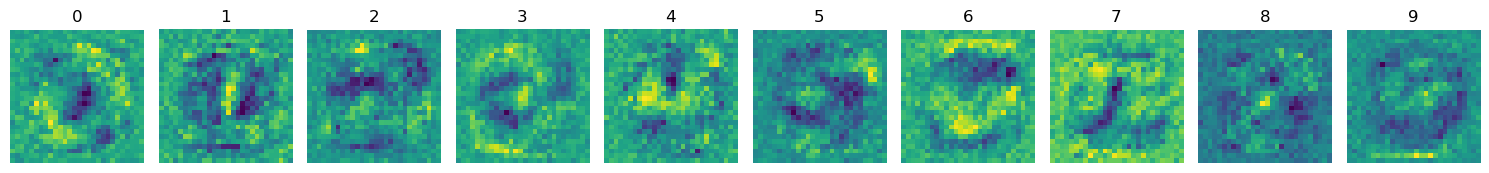

Iteration 12000 current batch loss: 0.07880118489265442
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979452, 0.9746, 0.981974, 0.984696, 0.978872, 0.985748, 0.974535, 0.987797, 0.969561, 0.980548]


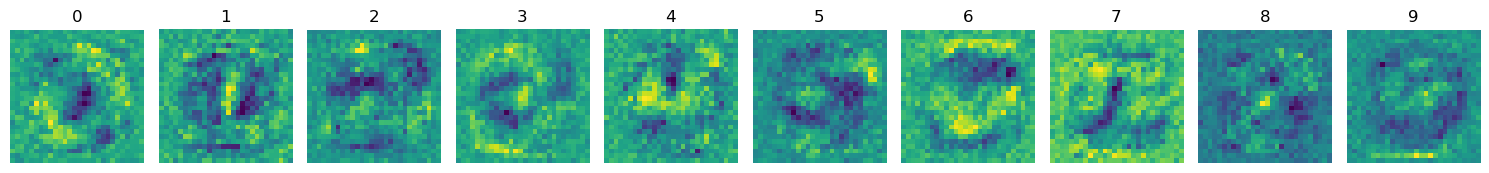

Iteration 14000 current batch loss: 0.07880114763975143
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979452, 0.974611, 0.981974, 0.984692, 0.978839, 0.985734, 0.974546, 0.987795, 0.969564, 0.98056]


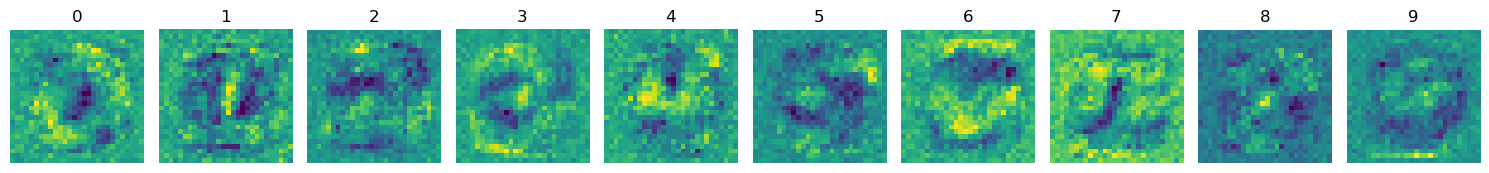

Iteration 16000 current batch loss: 0.07879944145679474
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979484, 0.974597, 0.981982, 0.984679, 0.978857, 0.985781, 0.974553, 0.987793, 0.969573, 0.980549]


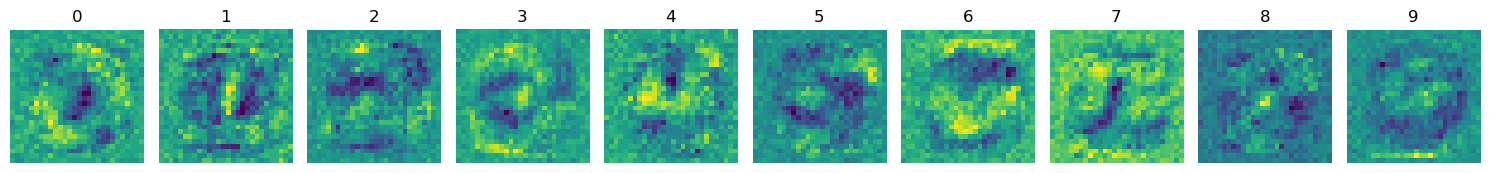

Iteration 18000 current batch loss: 0.07880166172981262
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979448, 0.974616, 0.981987, 0.984731, 0.978882, 0.985768, 0.974521, 0.987786, 0.969529, 0.980558]


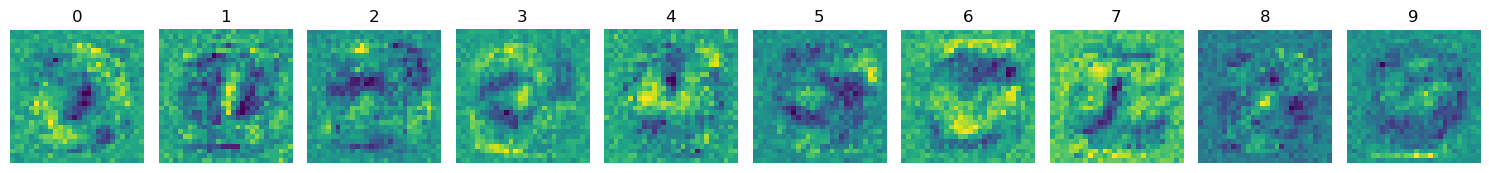

Iteration 20000 current batch loss: 0.07880239188671112
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.97945, 0.97459, 0.981998, 0.984709, 0.978857, 0.985789, 0.974551, 0.987803, 0.96955, 0.980556]


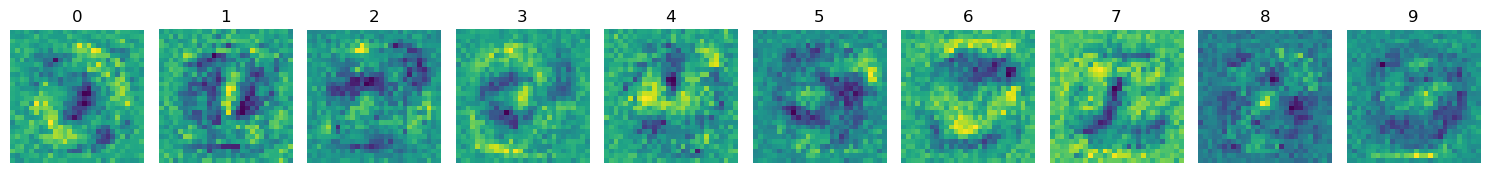

Iteration 22000 current batch loss: 0.07879817485809326
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.97946, 0.974591, 0.981989, 0.984714, 0.978855, 0.985768, 0.974534, 0.987789, 0.969551, 0.980561]


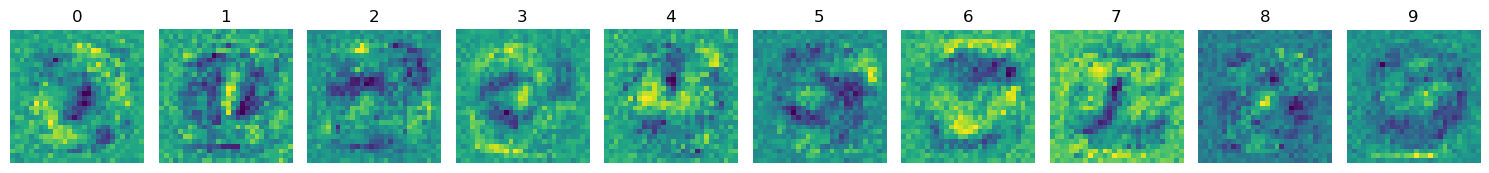

Iteration 24000 current batch loss: 0.07880410552024841
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979453, 0.974608, 0.981967, 0.984699, 0.978891, 0.985759, 0.974545, 0.987807, 0.969545, 0.980549]


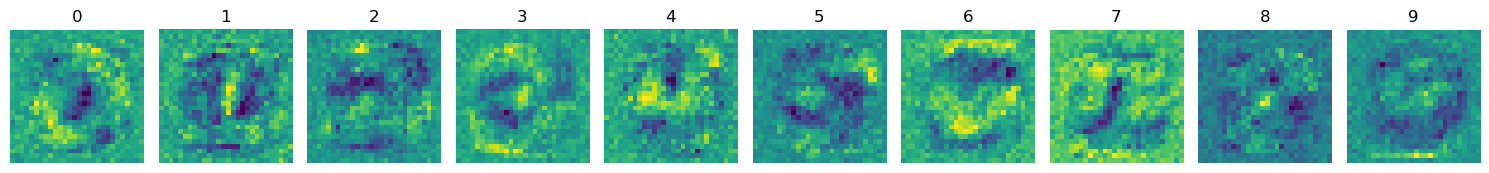

Iteration 26000 current batch loss: 0.07879984378814697
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979457, 0.974609, 0.981989, 0.984715, 0.978885, 0.985742, 0.974542, 0.987801, 0.969559, 0.98056]


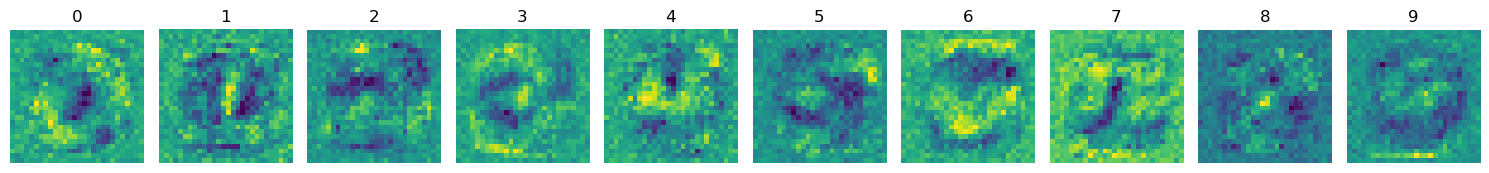

Iteration 28000 current batch loss: 0.07880055904388428
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979481, 0.974578, 0.981994, 0.984697, 0.978895, 0.98576, 0.974547, 0.987806, 0.969556, 0.980564]


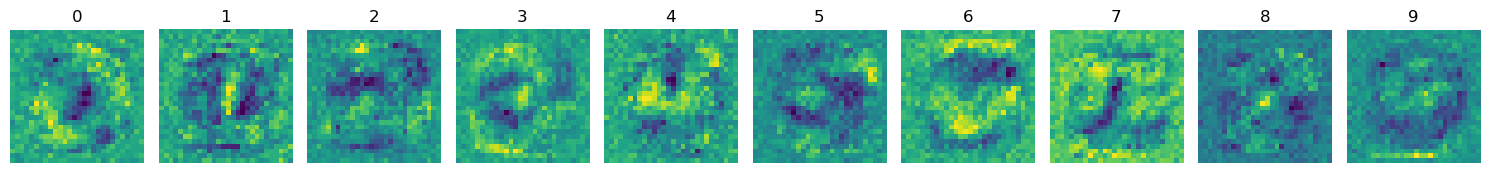

Iteration 30000 current batch loss: 0.07880017161369324
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979472, 0.974607, 0.981991, 0.984692, 0.978871, 0.985723, 0.974563, 0.987787, 0.969567, 0.98054]


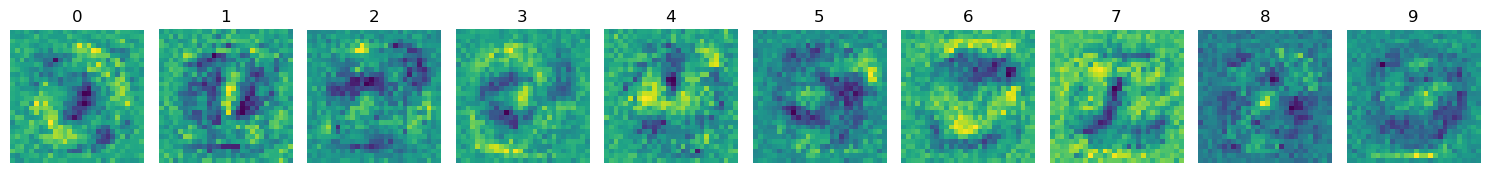

Iteration 32000 current batch loss: 0.07880245894193649
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979458, 0.974566, 0.981973, 0.984686, 0.978868, 0.985777, 0.974544, 0.987793, 0.969549, 0.980558]


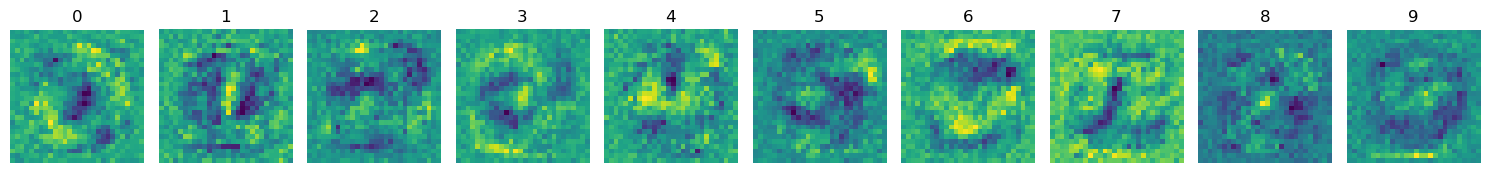

Iteration 34000 current batch loss: 0.07880040258169174
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979465, 0.974622, 0.981996, 0.984679, 0.978836, 0.985754, 0.974547, 0.987793, 0.969545, 0.980561]


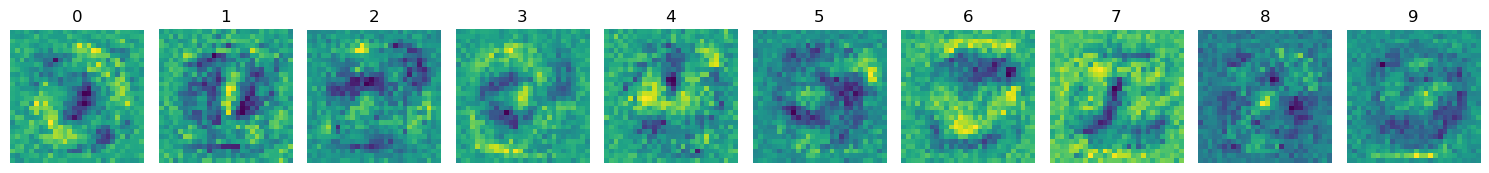

Iteration 36000 current batch loss: 0.07880011945962906
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979469, 0.974603, 0.981991, 0.984699, 0.978872, 0.985746, 0.97454, 0.987798, 0.969543, 0.980555]


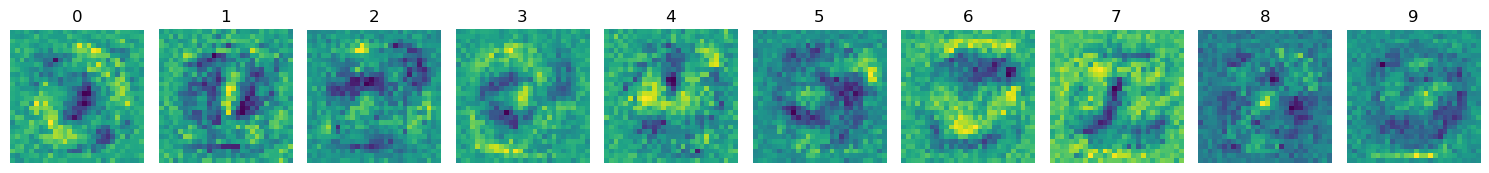

Iteration 38000 current batch loss: 0.07879848778247833
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979459, 0.974608, 0.981975, 0.984715, 0.978876, 0.985729, 0.974535, 0.987791, 0.969558, 0.980568]


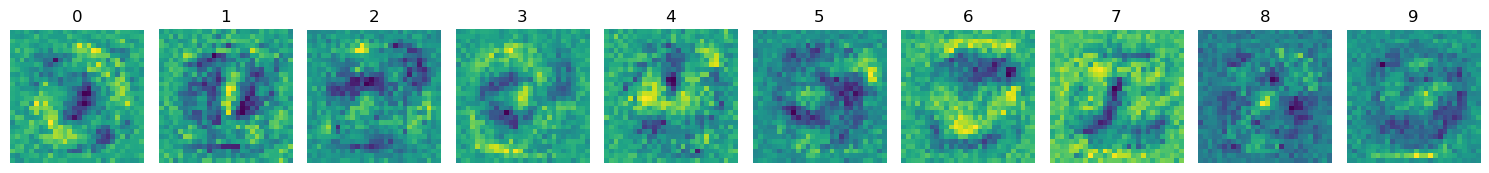

Iteration 40000 current batch loss: 0.07880115509033203
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.979459, 0.974587, 0.981991, 0.984681, 0.978834, 0.985738, 0.974545, 0.987798, 0.969545, 0.980569]


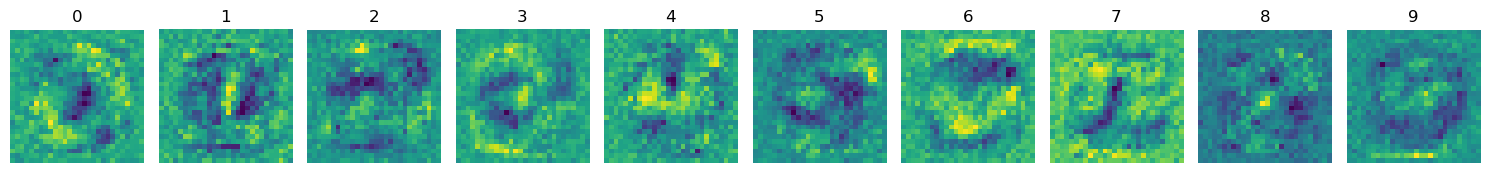

Iteration 40000 current batch loss: 0.07880115509033203


In [18]:
points_6 = train_input(net, lambda_l2 = 10, plot = True)

In [19]:
print("The end!")

The end!


lambda = 0


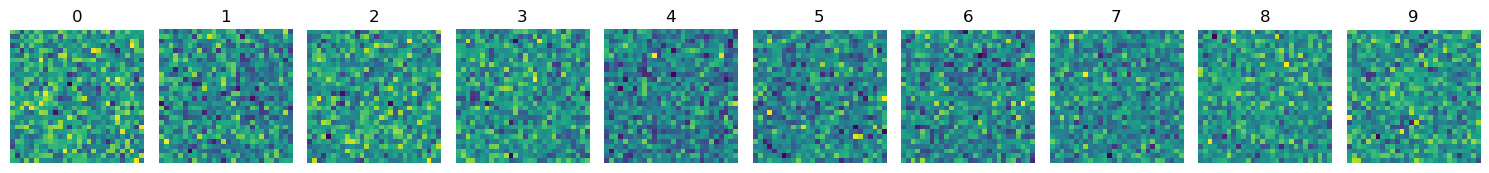

lambda = 0.001


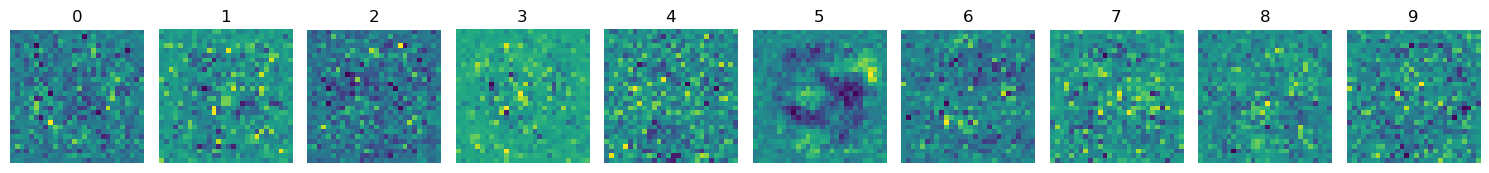

lambda = 0.01


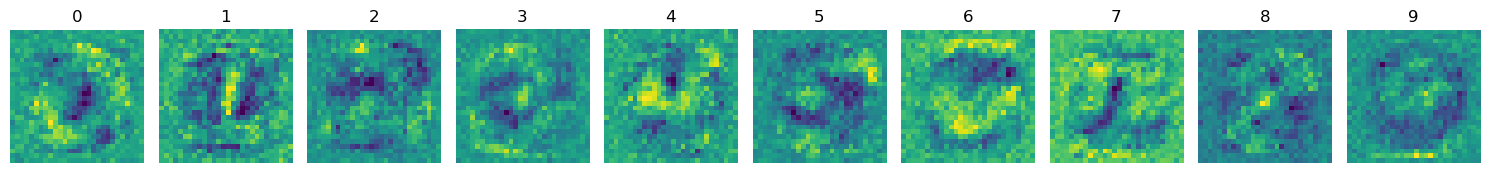

lambda = 0.1


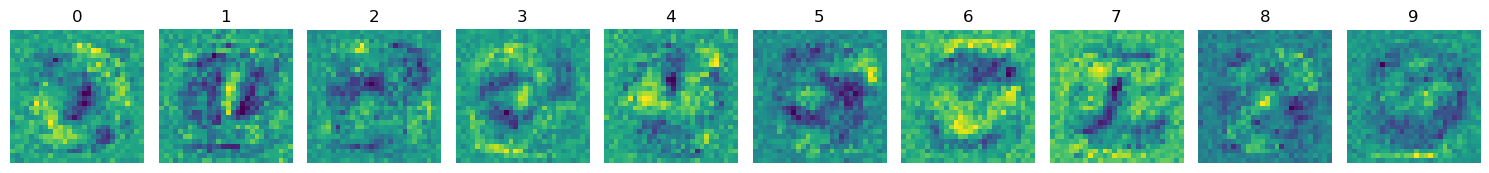

lambda = 1


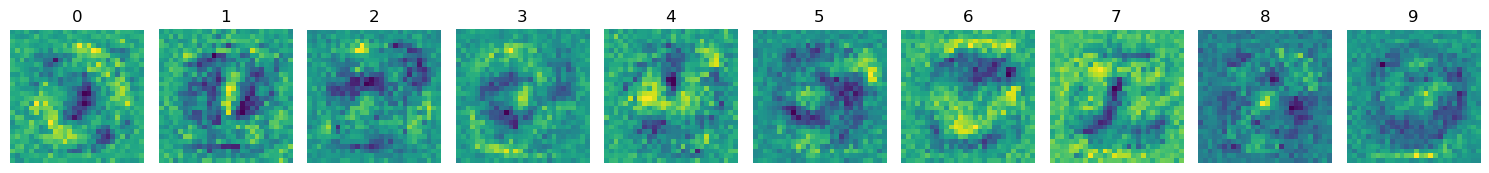

lambda = 10


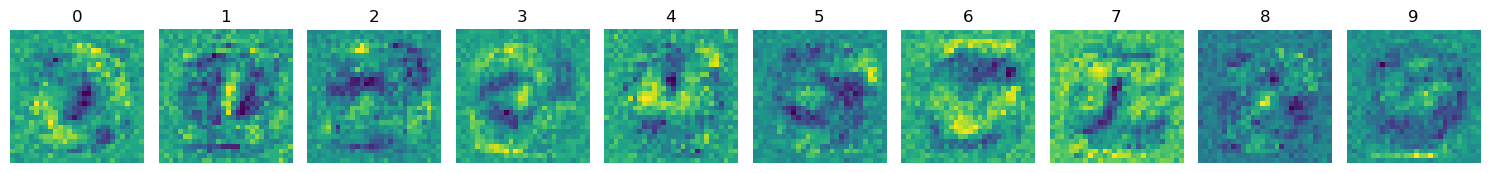

In [30]:
print("lambda = 0")
plot_numbers(points_1)
print("lambda = 0.001")
plot_numbers(points_2)
print("lambda = 0.01")
plot_numbers(points_3)
print("lambda = 0.1")
plot_numbers(points_4)
print("lambda = 1")
plot_numbers(points_5)
print("lambda = 10")
plot_numbers(points_6)   # final plots

# Conclusions

- **Recognizability depends on regularization.** Except when $\lambda = 0$ and $\lambda = 0.001$, the optimized inputs resemble valid MNIST digits. With no regularization ($\lambda = 0$) or with small regularization, the results bear little resemblance to any digit.
- **Model overconfidence at low $\lambda$.** Smaller values of $\lambda$ produce inputs the network classifies with very high confidence—likely because the optimization exploits isolated, distinctive pixels rather than coherent digit shapes.
- **$\lambda$ acts as a smoothing regularizer.** Increasing $\lambda$ encourages smoother, more natural-looking digit patterns by penalizing extreme pixel values.



# Creating two or more similar numbers

Let's focus on task of generating an image that bares similarity to two or more digits simultaneously. To accomplish this, we’ll define a loss function that is the sum of the cross-entropy losses for each digit that our generated image is meant to resemble.

In [31]:
def plot_similar_numbers(points):   # function for plotting

    img = points.squeeze().detach().cpu().numpy()
    pyplot.imshow(img)                 
    pyplot.tight_layout()
    pyplot.show()

def train_input_similar_numbers(net, numbers, lambda_l2 = 0, lr = 0.001, plot = False, info = 2000, max_iter = 40000):
    
    net.eval()
    for parameters in net.parameters():
        parameters.requires_grad = False   # freezing model
    
    points = torch.randn(1, 1, 28, 28).to(device)
    points.requires_grad = True   # creating random noise
        
    optimizer = torch.optim.Adam([points], lr)   

    epoch = 0
    
    while epoch < max_iter:
    
        loss = 0
        optimizer.zero_grad()
        preds = net(points)
        for number in numbers:
            true = torch.tensor([number], dtype=torch.long, device=device)
            loss += torch.nn.functional.cross_entropy(preds, true, reduction = "mean") + lambda_l2 * points.pow(2).mean()   # definition of our loss function
    
        epoch += 1
        if epoch % info == 0:
            print("Iteration", epoch, "current batch loss:", loss.item())
            preds_list = torch.nn.functional.softmax(net(points), dim = 1).tolist()[0]
            print("Predicted probabilities: ", [round(pred, 6) for pred in preds_list])
            if plot:
                plot_similar_numbers(points)
        
        loss.backward()     
        optimizer.step()     

    print("Iteration", epoch, "current batch loss:", loss.item())

    for parameters in net.parameters():
        parameters.requires_grad = False
        
    return points

Iteration 2000 current batch loss: 2.2708563804626465
Predicted probabilities:  [0.493823, 0.000826, 0.00279, 0.000486, 0.000557, 0.000759, 0.004218, 0.001775, 0.492965, 0.001801]


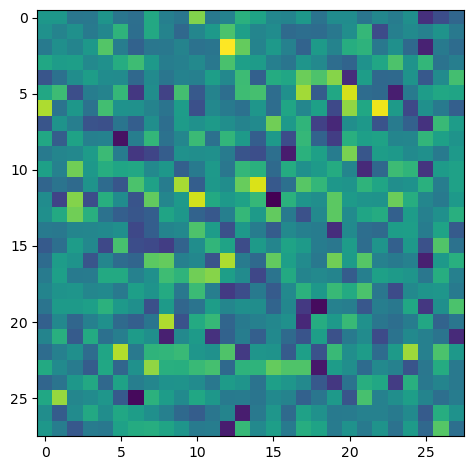

Iteration 4000 current batch loss: 1.5979372262954712
Predicted probabilities:  [0.495646, 0.000827, 0.001958, 0.000582, 0.00054, 0.00043, 0.002811, 0.001248, 0.494757, 0.001202]


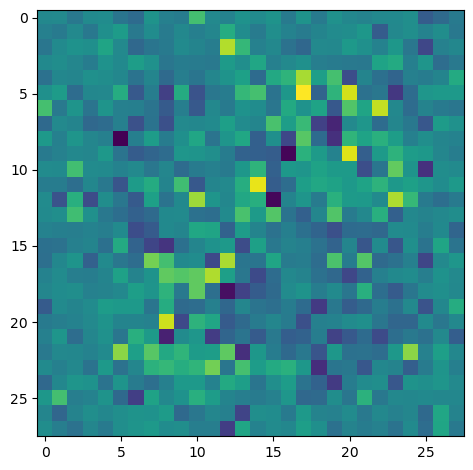

Iteration 6000 current batch loss: 1.4590946435928345
Predicted probabilities:  [0.496302, 0.000706, 0.001533, 0.000588, 0.000451, 0.000391, 0.002221, 0.001029, 0.495498, 0.001282]


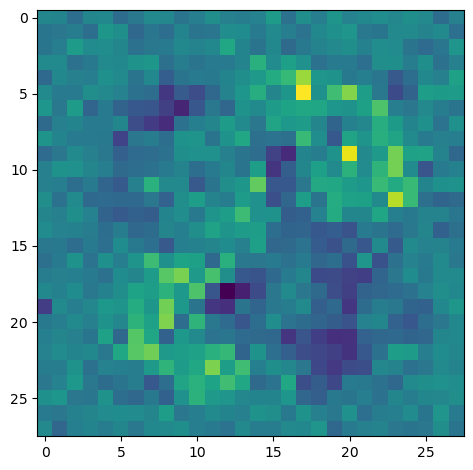

Iteration 8000 current batch loss: 1.4498040676116943
Predicted probabilities:  [0.496363, 0.000668, 0.001488, 0.000543, 0.000422, 0.000377, 0.002113, 0.001003, 0.495686, 0.001337]


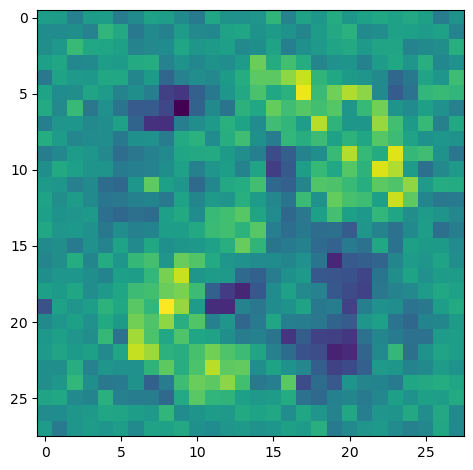

Iteration 10000 current batch loss: 1.449754238128662
Predicted probabilities:  [0.495885, 0.000668, 0.001479, 0.000539, 0.00042, 0.000378, 0.002107, 0.001006, 0.496177, 0.001342]


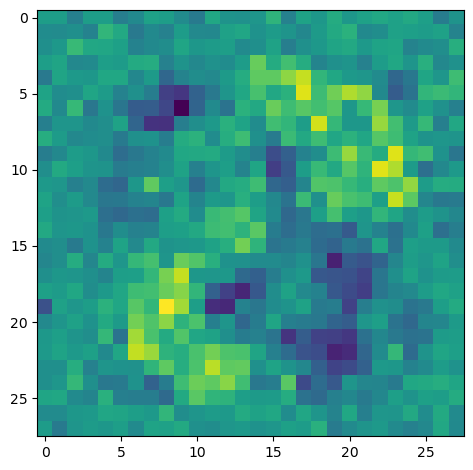

Iteration 12000 current batch loss: 1.449756145477295
Predicted probabilities:  [0.496568, 0.000667, 0.00148, 0.000538, 0.00042, 0.000378, 0.002108, 0.001006, 0.495494, 0.001342]


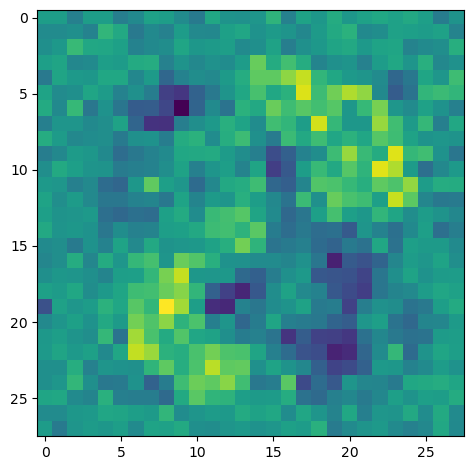

Iteration 14000 current batch loss: 1.4497584104537964
Predicted probabilities:  [0.496694, 0.000667, 0.00148, 0.000538, 0.00042, 0.000378, 0.00211, 0.001005, 0.495368, 0.001341]


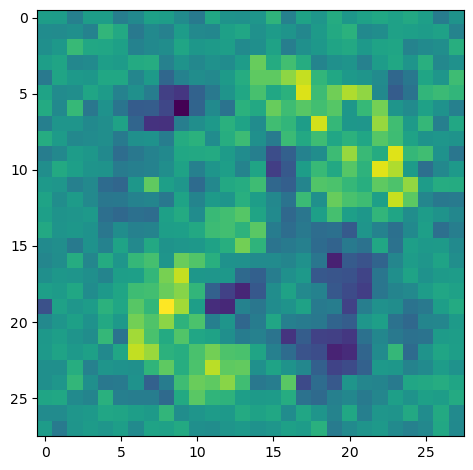

Iteration 16000 current batch loss: 1.449756383895874
Predicted probabilities:  [0.497127, 0.000667, 0.00148, 0.000538, 0.00042, 0.000378, 0.002108, 0.001007, 0.494934, 0.001342]


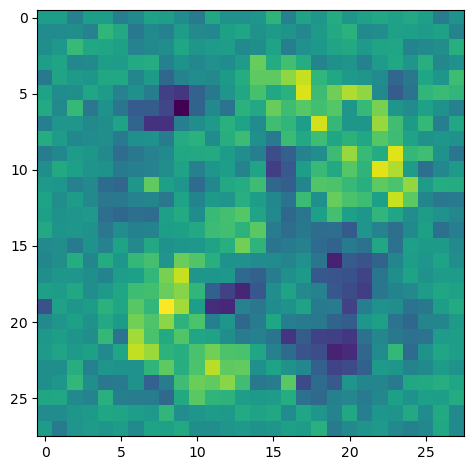

Iteration 18000 current batch loss: 1.4497586488723755
Predicted probabilities:  [0.49589, 0.000668, 0.001482, 0.000539, 0.000419, 0.000378, 0.002108, 0.001005, 0.49617, 0.001342]


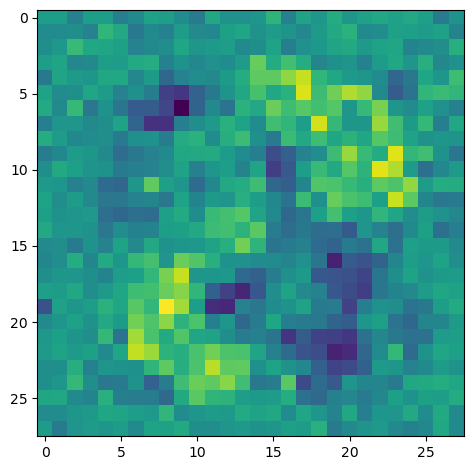

Iteration 20000 current batch loss: 1.449756145477295
Predicted probabilities:  [0.496162, 0.000668, 0.001478, 0.000538, 0.00042, 0.000379, 0.002108, 0.001007, 0.4959, 0.001342]


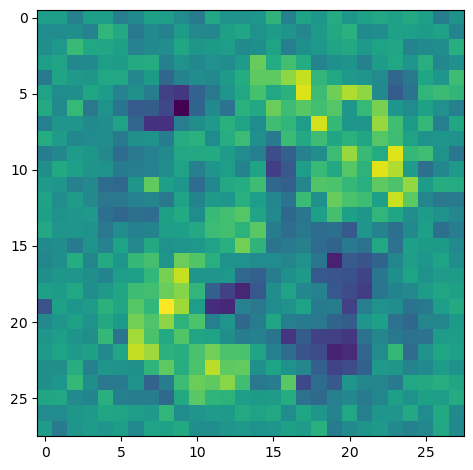

Iteration 22000 current batch loss: 1.4497551918029785
Predicted probabilities:  [0.496638, 0.000667, 0.001477, 0.000538, 0.00042, 0.000378, 0.002109, 0.001006, 0.495425, 0.001342]


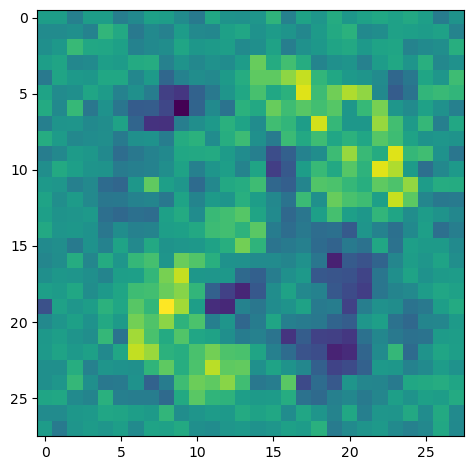

Iteration 24000 current batch loss: 1.4497625827789307
Predicted probabilities:  [0.497615, 0.000667, 0.001478, 0.000538, 0.000419, 0.000378, 0.002106, 0.001008, 0.494449, 0.001342]


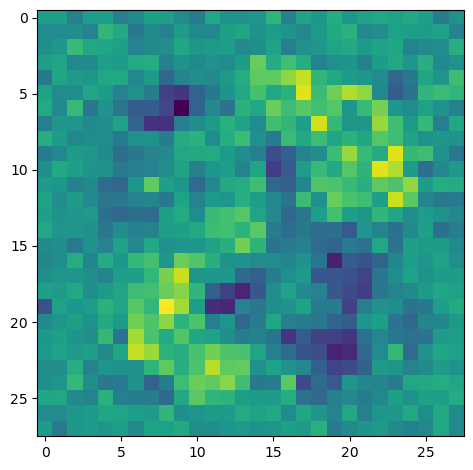

Iteration 26000 current batch loss: 1.449753761291504
Predicted probabilities:  [0.49596, 0.000667, 0.001481, 0.000539, 0.00042, 0.000378, 0.00211, 0.001004, 0.496099, 0.001341]


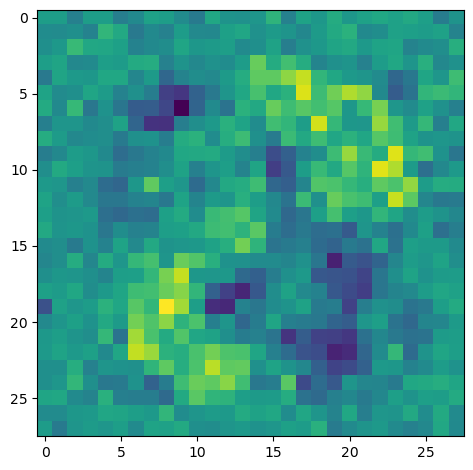

Iteration 28000 current batch loss: 1.4497592449188232
Predicted probabilities:  [0.497142, 0.000667, 0.001479, 0.000537, 0.00042, 0.000377, 0.002109, 0.001006, 0.494924, 0.001339]


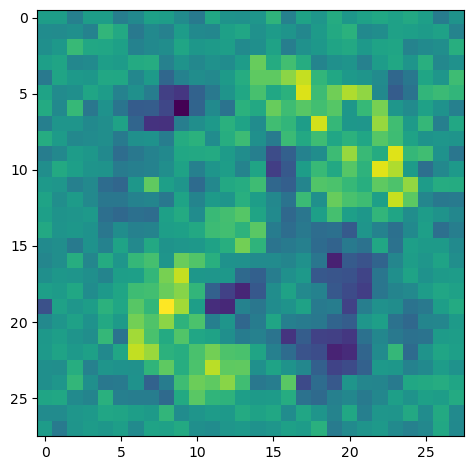

Iteration 30000 current batch loss: 1.4497555494308472
Predicted probabilities:  [0.496391, 0.000667, 0.001476, 0.000538, 0.00042, 0.000379, 0.002109, 0.001007, 0.495671, 0.001342]


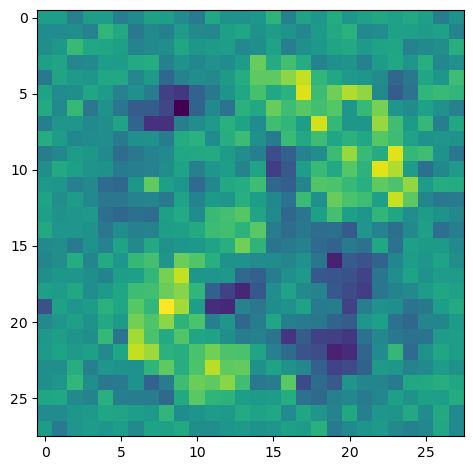

Iteration 32000 current batch loss: 1.4497531652450562
Predicted probabilities:  [0.496529, 0.000667, 0.00148, 0.000539, 0.00042, 0.000378, 0.002106, 0.001006, 0.495533, 0.001342]


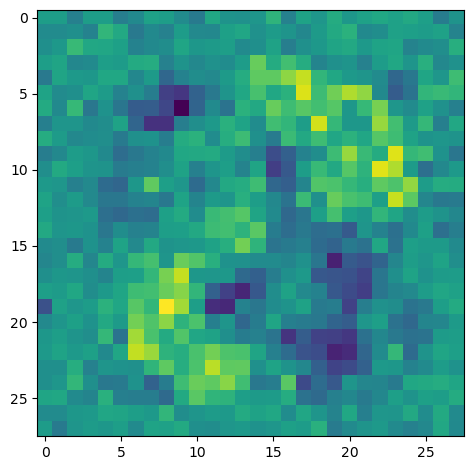

Iteration 34000 current batch loss: 1.4497562646865845
Predicted probabilities:  [0.497042, 0.000667, 0.001479, 0.000538, 0.00042, 0.000378, 0.002108, 0.001007, 0.49502, 0.001342]


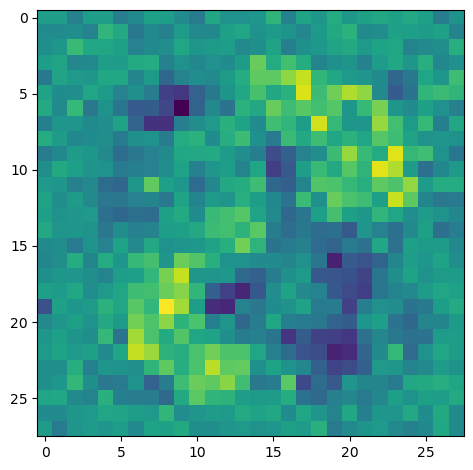

Iteration 36000 current batch loss: 1.4497565031051636
Predicted probabilities:  [0.496065, 0.000667, 0.00148, 0.000539, 0.00042, 0.000377, 0.002109, 0.001005, 0.495995, 0.001341]


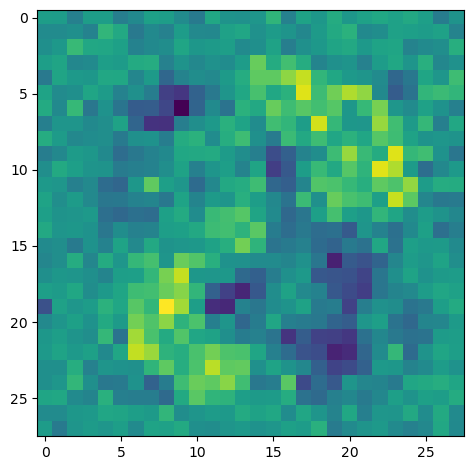

Iteration 38000 current batch loss: 1.4497660398483276
Predicted probabilities:  [0.49779, 0.000667, 0.00148, 0.000538, 0.00042, 0.000378, 0.002108, 0.001007, 0.494274, 0.00134]


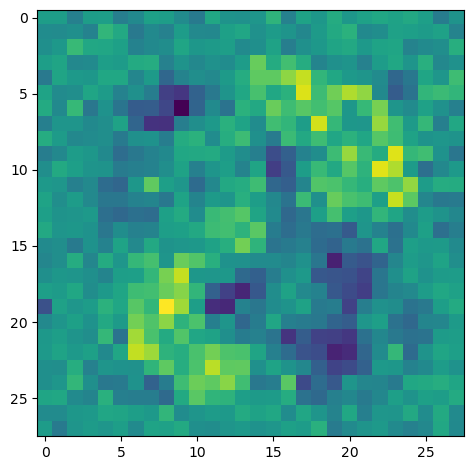

Iteration 40000 current batch loss: 1.4497581720352173
Predicted probabilities:  [0.495706, 0.000667, 0.001479, 0.000539, 0.00042, 0.000377, 0.002108, 0.001005, 0.496358, 0.001342]


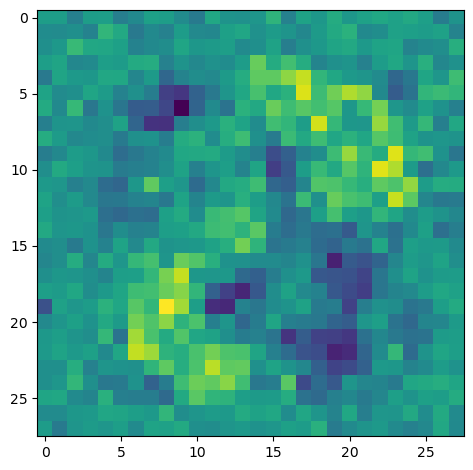

Iteration 40000 current batch loss: 1.4497581720352173


In [34]:
points = train_input_similar_numbers(net, [0, 8], lambda_l2 = 1, plot = True)

In [33]:
print("The end!")

The end!


# Conclusions

Unfortunately, our number is not recognisable for us, but for the model the image bares similarity to two previously defined numbers. The model predicts the probability of 0 and 8 to be equal approximately 0.5. 